In [64]:
import pandas as pd
import sqlite3
from sqlite3 import Error
import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, make_scorer
#import mlflow
#import mlflow.sklearn


In [ ]:
!pip install ydata-profiling
!pip install mlflow

  Using cached dacite-1.8.1-py3-none-any.whl.metadata (15 kB)
Using cached dacite-1.8.1-py3-none-any.whl (14 kB)
  Attempting uninstall: dacite
    Found existing installation: dacite 1.6.0
    Uninstalling dacite-1.6.0:
      Successfully uninstalled dacite-1.6.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dagshub 0.4.0 requires dacite~=1.6.0, but you have dacite 1.8.1 which is incompatible.


## Project 

In [66]:
data = []
header = []
with open("data/Train.csv") as file:
    for lines in file:
        line = lines.strip()
        if line:
            if not header:
                header = line.split(",")
            else:
                data.append(line.split(","))
print(header)
print(data)

['customerid', 'gender', 'ever_married', 'age', 'graduated', 'profession', 'work_experience', 'spending_score', 'family_size', 'var_1', 'category']
[['462809', 'Male', 'No', '22', 'No', 'Healthcare', '1', 'Low', '4', '0', '3'], ['466315', 'Female', 'Yes', '67', 'Yes', 'Engineer', '1', 'Low', '1', '1', '1'], ['461735', 'Male', 'Yes', '67', 'Yes', 'Lawyer', '0', 'High', '2', '1', '1'], ['461319', 'Male', 'Yes', '56', 'No', 'Artist', '0', 'Average', '2', '1', '2'], ['460156', 'Male', 'No', '32', 'Yes', 'Healthcare', '1', 'Low', '3', '1', '2'], ['464347', 'Female', 'No', '33', 'Yes', 'Healthcare', '1', 'Low', '3', '1', '3'], ['465015', 'Female', 'Yes', '61', 'Yes', 'Engineer', '0', 'Low', '3', '2', '3'], ['465176', 'Female', 'Yes', '55', 'Yes', 'Artist', '1', 'Average', '4', '1', '2'], ['464041', 'Female', 'No', '26', 'Yes', 'Engineer', '1', 'Low', '3', '1', '0'], ['464942', 'Male', 'No', '19', 'No', 'Healthcare', '4', 'Low', '4', '0', '3'], ['460849', 'Female', 'Yes', '58', 'No', 'Doctor'

In [ ]:

def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn


def create_table(conn, create_table_sql):
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows

## Normalization
### Customer table<br>
ID <BR>
Gender <BR>
Ever_Married <BR>
Age <BR>
Graduated <BR>
ProfessionID <BR>
Work_Experience <BR>
Spending_ScoreID <BR>
Family_Size <BR>
Var_1ID <BR>
SegementationID <BR>

### Profession table<br>
ProfessionID <BR>
ProfessionName <BR>

### Spending_Score table<br>
Spending_ScoreID <BR>
Spending_Score <BR>

### Var_1 table<br>
Var_1ID <BR>
Var_1 <BR>

### Segmentation table<br>
SegementationID <BR>
Segementation <BR>

In [ ]:
conn = create_connection('data/customer_categorize.db',True)

In [ ]:
sql_creating_prof = """
create table Profession(
[ProfessionID] Integer NOT NULL PRIMARY KEY,
[ProfessionName] Text not null
)
"""
#execute_sql_statement("DROP TABLE Profession", conn)
create_table(conn, sql_creating_prof)



In [ ]:
sql_creating_VAR = """
create table VAR_1(
[VAR_1ID] Integer NOT NULL PRIMARY KEY,
[VAR_1] Text not null
)
"""
#execute_sql_statement("DROP TABLE VAR_1", conn)
create_table(conn, sql_creating_VAR)

In [ ]:
sql_creating_ss = """
create table Spending_score(
[Spending_scoreID] Integer NOT NULL PRIMARY KEY,
[Spending_score] Text not null
)
"""
#execute_sql_statement("DROP TABLE Spending_score", conn)
create_table(conn, sql_creating_ss)

In [ ]:
sql_creating_segement = """
create table Segmentation(
[SegmentationID] Integer NOT NULL PRIMARY KEY,
[Segmentation] Text not null
)
"""
#execute_sql_statement("DROP TABLE Segmentation", conn)
create_table(conn, sql_creating_segement)


In [ ]:
sql_creating_gender = """
create table Gender(
[GenderID] Integer NOT NULL PRIMARY KEY,
[Gender] Text not null
)
"""
#execute_sql_statement("DROP TABLE Gender", conn)
create_table(conn, sql_creating_gender)

In [ ]:
sql_creating_customer = """
CREATE TABLE Customer (
    CustomerID INT PRIMARY KEY,
    GenderID INT,
    Ever_Married text,
    Age int,
    Graduated text,
    ProfessionID INT,
    Work_Experience int,
    Spending_ScoreID INT,
    Family_Size INT,
    VAR_1ID INT,
    SegmentationID INT,
    FOREIGN KEY (GenderID) REFERENCES Gender(GenderID),
    FOREIGN KEY (ProfessionID) REFERENCES Profession(ProfessionID),
    FOREIGN KEY (Spending_ScoreID) REFERENCES Spending_Score(Spending_ScoreID),
    FOREIGN KEY (VAR_1ID) REFERENCES Var_1(VAR_1ID),
    FOREIGN KEY (SegmentationID) REFERENCES Segmentation(SegmentationID)
);

"""
#execute_sql_statement("DROP TABLE Customer", conn)
create_table(conn, sql_creating_customer)

In [ ]:


gender = []
profession = []
spending_score = []
var_1 = []
segmentation = []

#'ID', 'Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession', 'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1', 'Segmentation'
header_temp = []
with open("data/Train.csv") as file:
    for line in file:
        line = line.strip()
        if line:
            line = line.split(",")
            #print(len(line))
            if not header_temp:
                header_temp = line
            else:
                if line[1] and line[1] not in gender:
                    gender.append(line[1])
                if line[5] and line[5] not in profession:
                    profession.append(line[5])
                if line[7] and line[7] not in spending_score:
                    spending_score.append(line[7])
                if line[9] and line[9] not in var_1:
                    var_1.append(line[9])
                if line[10] and line[10] not in segmentation:
                    segmentation.append(line[10])

dict_profession = {key:val for key,val in zip(profession, range(0,len(profession)))}
dict_gender = {key:val for key,val in zip(gender, range(0,len(gender)))}
dict_segmentation = {key:val for key,val in zip(segmentation, range(0,len(segmentation)))}
dict_spending_score = {key:val for key,val in zip(spending_score, range(0,len(spending_score)))}
dict_var_1 = {key:val for key,val in zip(var_1, range(0,len(var_1)))}

print(dict_gender)
print(dict_profession)
print(dict_spending_score)
print(dict_var_1)
print(dict_segmentation)


{'Male': 0, 'Female': 1}
{'Healthcare': 0, 'Engineer': 1, 'Lawyer': 2, 'Artist': 3, 'Doctor': 4, 'Homemaker': 5, 'Entertainment': 6, 'Marketing': 7, 'Executive': 8}
{'Low': 0, 'High': 1, 'Average': 2}
{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6}
{'3': 0, '1': 1, '2': 2, '0': 3}


In [ ]:
val = [list(ele) for ele in dict_gender.items()]
sql_insert_gender = """
Insert into Gender(GenderID, Gender) Values(?,?)
"""
for v in val:
    conn.execute(sql_insert_gender, [v[1],v[0]])
conn.commit()

In [ ]:
val = [list(ele) for ele in dict_profession.items()]
sql_insert_profession = """
Insert into profession(professionID, ProfessionName) Values(?,?)
"""
for v in val:
    conn.execute(sql_insert_profession, [v[1],v[0]])
conn.commit()

In [ ]:
val = [list(ele) for ele in dict_segmentation.items()]
sql_insert_segmentation = """
Insert into segmentation(segmentationID, segmentation) Values(?,?)
"""
for v in val:
    conn.execute(sql_insert_segmentation, [v[1],v[0]])
conn.commit()

In [ ]:
val = [list(ele) for ele in dict_spending_score.items()]
sql_insert_spending_score = """
Insert into spending_score(spending_scoreID, spending_score) Values(?,?)
"""
for v in val:
    conn.execute(sql_insert_spending_score, [v[1],v[0]])
conn.commit()

In [ ]:
val = [list(ele) for ele in dict_var_1.items()]
sql_insert_var_1 = """
Insert into var_1(var_1ID, var_1) Values(?,?)
"""
for v in val:
    conn.execute(sql_insert_var_1, [v[1],v[0]])
conn.commit()

In [ ]:
header_temp = []
sql_insert_customer = """
insert into customer(
    CustomerID ,
    GenderID ,
    Ever_Married,
    Age ,
    Graduated ,
    ProfessionID ,
    Work_Experience ,
    Spending_ScoreID ,
    Family_Size ,
    VAR_1ID ,
    SegmentationID 
) Values (?,?,?,?,?,?,?,?,?,?,?)
"""

with open("data/Train.csv") as file:
    for line in file:
        line = line.strip()
        if line:
            line = line.split(",")
        
            if not header_temp:
                header_temp = line
            else:
                if "" not in line:
                    line[1] = dict_gender[line[1]]
                    line[3] = float(line[3].strip())
                    line[5] = dict_profession[line[5]]
                    line[6] = float(line[6].strip())
                    line[7] = dict_spending_score[line[7]]
                    line[8] = float(line[8].strip())
                    line[9] = dict_var_1[line[9]]
                    line[10] = dict_segmentation[line[10]]
                    
                    conn.execute(sql_insert_customer, line)
conn.commit()


In [ ]:
sql_statement_gettting_data = """
select
    c.customerid as customerid,
    g.gender as gender,
    c.ever_married as ever_married,
    c.age as age,
    c.graduated as graduated,
    p.professionname as profession,
    c.work_experience as work_experience,
    ss.spending_score as spending_score,
    c.family_size as family_size,
    v.var_1id as var_1,
    s.segmentation as category
from 
    customer c
left outer join profession p on p.professionid = c.professionid
left outer join gender g on g.genderid = c.genderid
left outer join segmentation s on s.segmentationid = c.segmentationid
left outer join spending_score ss on ss.spending_scoreid = c.spending_scoreid
left outer join var_1 v on v.var_1id = c.var_1id

"""


df = pd.read_sql(sql_statement_gettting_data, conn)

In [ ]:
conn.close()

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['category'] = label_encoder.fit_transform(df['category'])
df.head()

customerid  gender ever_married  age graduated  profession  \
0      462809    Male           No   22        No  Healthcare   
1      466315  Female          Yes   67       Yes    Engineer   
2      461735    Male          Yes   67       Yes      Lawyer   
3      461319    Male          Yes   56        No      Artist   
4      460156    Male           No   32       Yes  Healthcare   

   work_experience spending_score  family_size  var_1  category  
0                1            Low            4      0         3  
1                1            Low            1      1         1  
2                0           High            2      1         1  
3                0        Average            2      1         2  
4                1            Low            3      1         2

<Figure size 800x600 with 0 Axes>

<Axes: xlabel='category'>

Text(0.5, 1.0, 'Category Distribution')

Text(0.5, 0, 'Category')

Text(0, 0.5, 'Count')

(array([0, 1, 2, 3]),
 [Text(0, 0, '3'), Text(1, 0, '2'), Text(2, 0, '0'), Text(3, 0, '1')])

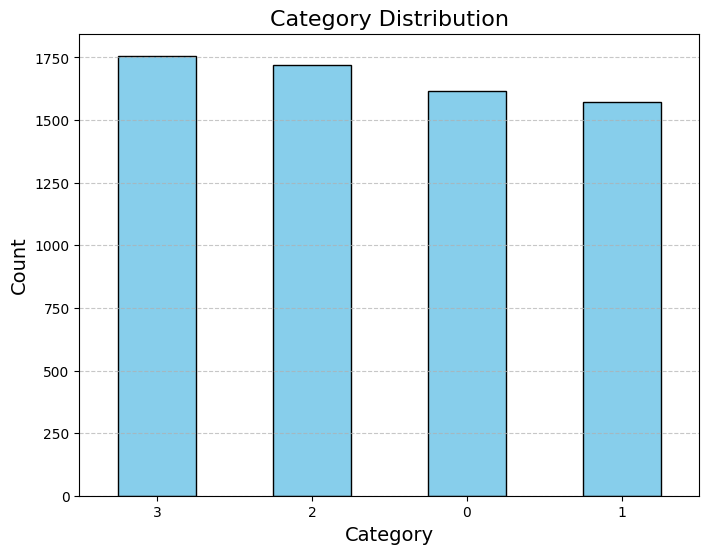

In [ ]:
class_counts = df['category'].value_counts()
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Category Distribution', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
import pandas as pd
from ydata_profiling import ProfileReport



# Generate profile report
profile = ProfileReport(df, title="Customer Segmentation Report", explorative=True)

profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Setting Customerid as the index since they have no duplicates

In [ ]:
df.set_index("customerid", inplace = True)

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'work_experience'}>],
       [<Axes: title={'center': 'family_size'}>,
        <Axes: title={'center': 'var_1'}>]], dtype=object)

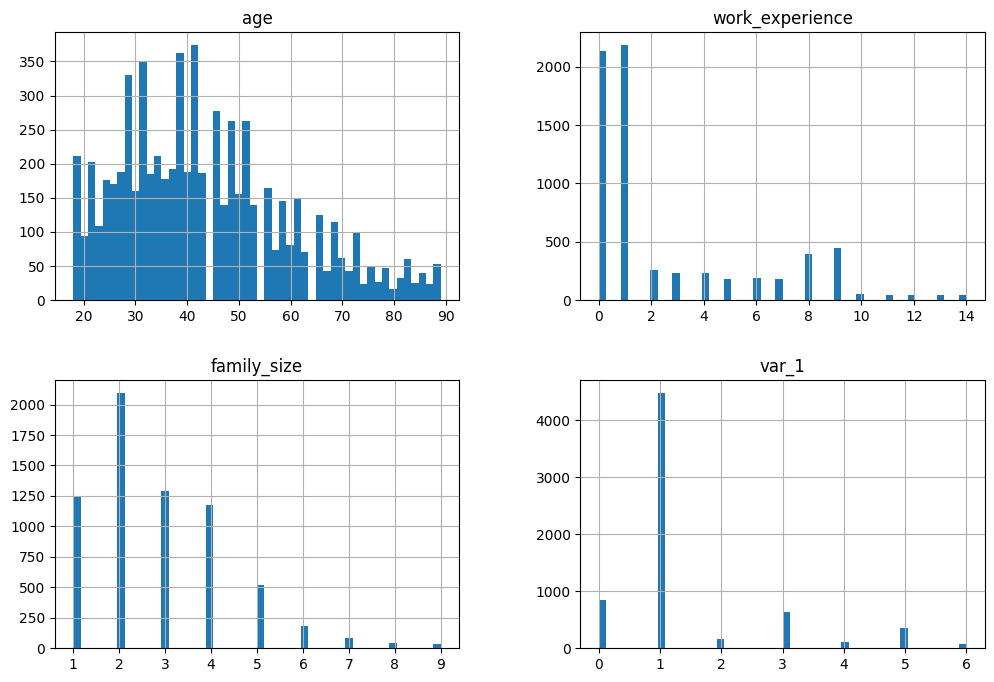

In [ ]:
df.iloc[:,:-1].hist(bins=50, figsize=(12, 8))
plt.show()

<Axes: title={'center': 'gender'}, xlabel='gender'>

Text(0.5, 0, 'gender')

Text(0, 0.5, 'Count')

<Axes: title={'center': 'ever_married'}, xlabel='ever_married'>

Text(0.5, 0, 'ever_married')

Text(0, 0.5, 'Count')

<Axes: title={'center': 'graduated'}, xlabel='graduated'>

Text(0.5, 0, 'graduated')

Text(0, 0.5, 'Count')

<Axes: title={'center': 'profession'}, xlabel='profession'>

Text(0.5, 0, 'profession')

Text(0, 0.5, 'Count')

<Axes: title={'center': 'spending_score'}, xlabel='spending_score'>

Text(0.5, 0, 'spending_score')

Text(0, 0.5, 'Count')

<Axes: title={'center': 'var_1'}, xlabel='var_1'>

Text(0.5, 0, 'var_1')

Text(0, 0.5, 'Count')

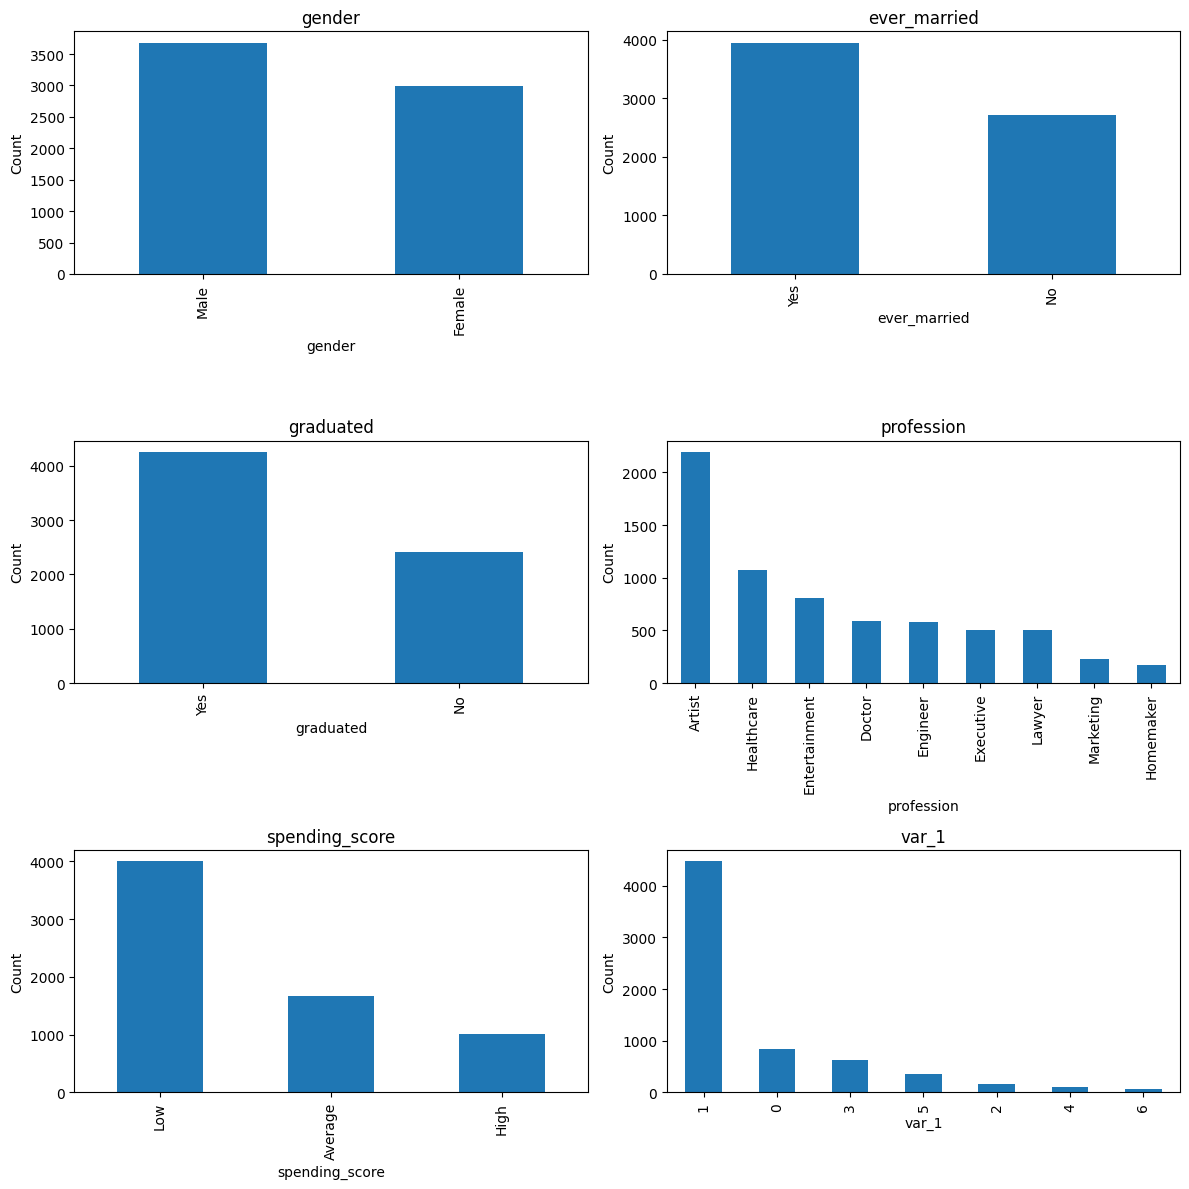

In [ ]:
categorical_features = ["gender", "ever_married", "graduated", "profession", "spending_score", "var_1"]
n_features = len(categorical_features)


fig, axes = plt.subplots(nrows=(n_features + 1) // 2, ncols=2, figsize=(12, 4 * ((n_features + 1) // 2)))
axes = axes.flatten()  

for i, col in enumerate(categorical_features):
    df[col].value_counts().plot(kind="bar", ax=axes[i], title=col)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Observations
 - From the Correlation heatmap generated we can see that age, marital status, graduation, profession and their spending score have some effect on how they are placed into categories
 - From the histogram we can tell that none of the values seem to be capped
 - Most customer in the market for automobile seem to new grads with little work experience

In [ ]:
from sklearn.model_selection import train_test_split
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df["spending_score"])
customer_segment = X_train.copy()

In [ ]:
from sklearn.preprocessing import OneHotEncoder



customer_segment_cat = customer_segment.select_dtypes(include=['object'])
cat_encoder = OneHotEncoder()
customer_segment_cat_1hot = cat_encoder.fit_transform(customer_segment_cat)
print(customer_segment_cat_1hot.toarray())
cat_encoder.categories_

[[1. 0. 0. ... 1. 0. 0.]
 [0. 1. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 1. 0. 0.]
 ...
 [1. 0. 0. ... 0. 1. 0.]
 [0. 1. 1. ... 0. 0. 1.]
 [1. 0. 1. ... 0. 0. 1.]]


[array(['Female', 'Male'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['Artist', 'Doctor', 'Engineer', 'Entertainment', 'Executive',
        'Healthcare', 'Homemaker', 'Lawyer', 'Marketing'], dtype=object),
 array(['Average', 'High', 'Low'], dtype=object)]

In [ ]:
customer_segment_num = customer_segment.select_dtypes(include=[np.number])
# Data Preprocessing -- Feature Scaling 
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
customer_segment_num_min_max_scaled = min_max_scaler.fit_transform(customer_segment_num)

from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
customer_segment_num_std_scaled = std_scaler.fit_transform(customer_segment_num)

from sklearn.preprocessing import FunctionTransformer
log_transformer = FunctionTransformer(lambda x: np.log(x + 1), inverse_func=np.exp)
log_pop = log_transformer.transform(customer_segment_num)

In [ ]:
%config InteractiveShell.ast_node_interactivity = "all"

## Experiment 1

In [ ]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("standardize", StandardScaler()),
])

num_pipeline




Pipeline(steps=[('standardize', StandardScaler())])

In [ ]:
def log_transform(x):
    return np.log1p(x)

family_size_pipeline = Pipeline([
    ("log_transform", FunctionTransformer(log_transform, validate=True)),
    ("standardize", StandardScaler())
])
 


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline


num_attribs = ["age", "work_experience"]
cat_attribs = ["gender", "ever_married", "graduated", "profession", "spending_score", "var_1"]


cat_pipeline = Pipeline([
    ("onehotencoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessing = ColumnTransformer([
    ("family_size",family_size_pipeline,["family_size"]),
    ("cat", cat_pipeline, cat_attribs),
    ("num", num_pipeline, num_attribs),
    
])

In [ ]:


customer_segment_prepared = preprocessing.fit_transform(customer_segment)

num_feature_names = [f"{attr}" for attr in num_attribs]  
cat_feature_names = preprocessing.transformers_[1][1].named_steps['onehotencoder'].get_feature_names_out(cat_attribs)

all_feature_names = np.concatenate([["family_size"],num_feature_names, cat_feature_names])

customer_segment_prepared_fr = pd.DataFrame(
    customer_segment_prepared,
    columns=all_feature_names,
    index=customer_segment.index)
customer_segment_prepared_fr

family_size  age  work_experience  gender_Female  gender_Male  \
customerid                                                                  
464859         0.309238  1.0              0.0            0.0          1.0   
461353         0.895748  0.0              1.0            0.0          1.0   
467313        -0.446903  0.0              1.0            0.0          1.0   
466952        -0.446903  0.0              1.0            0.0          1.0   
465687        -1.512626  0.0              1.0            0.0          1.0   
...                 ...  ...              ...            ...          ...   
467906         1.374961  1.0              0.0            1.0          0.0   
465445         2.131102  1.0              0.0            1.0          0.0   
459438        -0.446903  1.0              0.0            0.0          1.0   
463754         0.895748  0.0              1.0            1.0          0.0   
467249        -1.512626  1.0              0.0            1.0          0.0   

            ever_married_No  ever_married_Yes  graduated_No  graduated_Yes  \
customerid                                                                   
464859                  0.0               1.0           1.0            0.0   
461353                  0.0               1.0           0.0            0.0   
467313                  0.0               1.0           0.0            0.0   
466952                  0.0               1.0           1.0            0.0   
465687                  0.0               1.0           0.0            0.0   
...                     ...               ...           ...            ...   
467906                  1.0               0.0           0.0            0.0   
465445                  0.0               1.0           0.0            0.0   
459438                  0.0               1.0           1.0            0.0   
463754                  0.0               1.0           0.0            0.0   
467249                  0.0               1.0           0.0            0.0   

            profession_Artist  ...  spending_score_Average  \
customerid                     ...                           
464859                    0.0  ...                     0.0   
461353                    0.0  ...                     0.0   
467313                    0.0  ...                     0.0   
466952                    0.0  ...                     0.0   
465687                    0.0  ...                     1.0   
...                       ...  ...                     ...   
467906                    0.0  ...                     1.0   
465445                    0.0  ...                     1.0   
459438                    0.0  ...                     0.0   
463754                    0.0  ...                     1.0   
467249                    0.0  ...                     1.0   

            spending_score_High  spending_score_Low  var_1_0  var_1_1  \
customerid                                                              
464859                      0.0                 1.0      0.0      0.0   
461353                      0.0                 1.0      0.0      0.0   
467313                      0.0                 1.0      0.0      0.0   
466952                      0.0                 1.0      0.0      0.0   
465687                      0.0                 1.0      0.0      0.0   
...                         ...                 ...      ...      ...   
467906                      0.0                 0.0      0.0      0.0   
465445                      0.0                 1.0      0.0      0.0   
459438                      0.0                 1.0      0.0      0.0   
463754                      0.0                 0.0      0.0      0.0   
467249                      0.0                 1.0      0.0      0.0   

            var_1_2  var_1_3  var_1_4   var_1_5   var_1_6  
customerid                                                 
464859          0.0      0.0      0.0  0.084290 -0.481997  
461353          0.0      0.0      0.0  0.387839 -0.775880 

In [ ]:
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, classification_report
import os
model = LogisticRegression(max_iter=1000, random_state=42)


pipeline = Pipeline([
    ("preprocessor", preprocessing),
    ("classifier", model)
])

scoring = {
    "f1": make_scorer(f1_score, average="weighted"),
    "accuracy": "accuracy",
    "precision": "precision_weighted",
    "recall": "recall_weighted"
}


param_grid = {
    "classifier__C": [0.01, 0.1, 1, 10, 100],
    "classifier__solver": ["lbfgs", "liblinear"]
}

search = GridSearchCV(pipeline, param_grid, scoring="f1_weighted", cv=3, n_jobs=-1)
search.fit(customer_segment, y_train)


cv_results = cross_validate(search.best_estimator_, customer_segment, y_train, scoring=scoring, cv=10, return_train_score=True)
mean_cv_f1 = np.mean(cv_results["test_f1"])
std_cv_f1 = np.std(cv_results["test_f1"])


best_pipeline = search.best_estimator_
best_pipeline.fit(customer_segment, y_train)
y_pred = best_pipeline.predict(X_test)


f1 = f1_score(y_test, y_pred, average="weighted")

cm = confusion_matrix(y_test, y_pred)
classes = [0, 1, 2, 3]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')


cm_plot_path = "confusion_matrix.png"
plt.savefig(cm_plot_path)
plt.close()  
metrics = {}

for i, label in enumerate(classes):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    tn = cm.sum() - (tp + fp + fn)
    metrics[label] = {
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn,
    }


MLFLOW_TRACKING_URI="https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME']='Jyothismaria'
os.environ['MLFLOW_TRACKING_PASSWORD']='23ccfad0cc03f842ff9abd620ab983625766bd42'


import mlflow
from mlflow.models import infer_signature

mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)

mlflow.set_experiment("Experiment_2")

score = -search.best_score_
params = search.best_params_
with mlflow.start_run(run_name="logr"):
    mlflow.log_param("best_params", search.best_params_)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("mean_cv_f1", mean_cv_f1)
    mlflow.log_metric("std_cv_f1", std_cv_f1)
   
    mlflow.log_artifact(cm_plot_path, artifact_path="confusion_matrix")


    for label, metric in metrics.items():
        for metric_name, value in metric.items():
            mlflow.log_metric(f"{label}_{metric_name}", value)
    mlflow.sklearn.log_model(best_pipeline, "logistic_regression_pipeline")

os.remove(cm_plot_path)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('family_size',
                                                                         Pipeline(steps=[('log_transform',
                                                                                          FunctionTransformer(func=<function log_transform at 0x0000022823564F40>,
                                                                                                              validate=True)),
                                                                                         ('standardize',
                                                                                          StandardScaler())]),
                                                                         ['family_size']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ign...
                                                                         ['gender',
                                                                          'ever_married',
                                                                          'graduated',
                                                                          'profession',
                                                                          'spending_score',
                                                                          'var_1']),
                                                                        ('num',
                                                                         Pipeline(steps=[('standardize',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'work_experience'])])),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.01, 0.1, 1, 10, 100],
                         'classifier__solver': ['lbfgs', 'liblinear']},
             scoring='f1_weighted')

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('family_size',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<function log_transform at 0x0000022823564F40>,
                                                                                       validate=True)),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  ['family_size']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'ever_married',
                                                   'graduated', 'profession',
                                                   'spending_score', 'var_1']),
                                                 ('num',
                                                  Pipeline(steps=[('standardize',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'work_experience'])])),
                ('classifier',
                 LogisticRegression(C=1, max_iter=1000, random_state=42))])

<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 36.72222222222221, 'Predicted Labels')

Text(70.72222222222221, 0.5, 'True Labels')

Text(0.5, 1.0, 'Confusion Matrix')

<Experiment: artifact_location='mlflow-artifacts:/6a8eaa55ee484e7a8f2bd28a5080e912', creation_time=1734670325797, experiment_id='6', last_update_time=1734670325797, lifecycle_stage='active', name='Experiment_2', tags={}>

{'classifier__C': 1, 'classifier__solver': 'lbfgs'}

2024/12/19 23:54:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run logr at: https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow/#/experiments/6/runs/68412535a83a4b5a91877490b3cd0940
🧪 View experiment at: https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow/#/experiments/6


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer



In [ ]:

model =  RidgeClassifier(random_state=42)


pipeline = Pipeline([
    ("preprocessor", preprocessing),
    ("classifier", model)
])

scoring = {
    "f1": make_scorer(f1_score, average="weighted"),
    "accuracy": "accuracy",
    "precision": "precision_weighted",
    "recall": "recall_weighted"
}

 
param_grid = {
    "classifier__alpha": range(1, 100, 10),  # Regularization strength
    "classifier__solver": ["auto", "svd", "cholesky", "lsqr", "sag", "saga"],  # Valid solvers for RidgeClassifier
    "classifier__fit_intercept": [True, False]  # Whether to calculate the intercept
}

search = GridSearchCV(pipeline, param_grid, scoring="f1_weighted", cv=3, n_jobs=-1)
search.fit(customer_segment, y_train)

# Log cross-validation results
cv_results = cross_validate(search.best_estimator_, customer_segment, y_train, scoring=scoring, cv=10, return_train_score=True)
mean_cv_f1 = np.mean(cv_results["test_f1"])
std_cv_f1 = np.std(cv_results["test_f1"])

# Step 8: Train the model on the whole training data
best_pipeline = search.best_estimator_
best_pipeline.fit(customer_segment, y_train)
y_pred = best_pipeline.predict(X_test)

# Step 9: Calculate metrics on test data
f1 = f1_score(y_test, y_pred, average="weighted")
cm = confusion_matrix(y_test, y_pred)
classes = [0, 1, 2, 3]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Save plot to a temporary file
cm_plot_path = "confusion_matrix.png"
plt.savefig(cm_plot_path)
plt.close()  # Close the figure to avoid display issues

metrics = {}

for i, label in enumerate(classes):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    tn = cm.sum() - (tp + fp + fn)
    metrics[label] = {
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn,
    }


MLFLOW_TRACKING_URI="https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME']='Jyothismaria'
os.environ['MLFLOW_TRACKING_PASSWORD']='23ccfad0cc03f842ff9abd620ab983625766bd42'


import mlflow
from mlflow.models import infer_signature

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)

# Create a new MLflow Experiment
mlflow.set_experiment("Experiment_2")

score = -search.best_score_
params = search.best_params_
with mlflow.start_run(run_name="ridge"):
    mlflow.log_param("best_params", search.best_params_)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("mean_cv_f1", mean_cv_f1)
    mlflow.log_metric("std_cv_f1", std_cv_f1)
    # Log the confusion matrix plot as an artifact
    mlflow.log_artifact(cm_plot_path, artifact_path="confusion_matrix")

    # Optionally, log metrics or other details
    for label, metric in metrics.items():
        for metric_name, value in metric.items():
            mlflow.log_metric(f"{label}_{metric_name}", value)
    mlflow.sklearn.log_model(best_pipeline, "ridge_classifier_pipeline")

os.remove(cm_plot_path)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('family_size',
                                                                         Pipeline(steps=[('log_transform',
                                                                                          FunctionTransformer(func=<function log_transform at 0x0000022823564F40>,
                                                                                                              validate=True)),
                                                                                         ('standardize',
                                                                                          StandardScaler())]),
                                                                         ['family_size']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ign...
                                                                          'spending_score',
                                                                          'var_1']),
                                                                        ('num',
                                                                         Pipeline(steps=[('standardize',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'work_experience'])])),
                                       ('classifier',
                                        RidgeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__alpha': range(1, 100, 10),
                         'classifier__fit_intercept': [True, False],
                         'classifier__solver': ['auto', 'svd', 'cholesky',
                                                'lsqr', 'sag', 'saga']},
             scoring='f1_weighted')

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('family_size',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<function log_transform at 0x0000022823564F40>,
                                                                                       validate=True)),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  ['family_size']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'ever_married',
                                                   'graduated', 'profession',
                                                   'spending_score', 'var_1']),
                                                 ('num',
                                                  Pipeline(steps=[('standardize',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'work_experience'])])),
                ('classifier', RidgeClassifier(alpha=1, random_state=42))])

<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 36.72222222222221, 'Predicted Labels')

Text(70.72222222222221, 0.5, 'True Labels')

Text(0.5, 1.0, 'Confusion Matrix')

2024/12/19 23:52:05 INFO mlflow.tracking.fluent: Experiment with name 'Experiment_2' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/6a8eaa55ee484e7a8f2bd28a5080e912', creation_time=1734670325797, experiment_id='6', last_update_time=1734670325797, lifecycle_stage='active', name='Experiment_2', tags={}>

{'classifier__alpha': 1,
 'classifier__fit_intercept': True,
 'classifier__solver': 'auto'}

2024/12/19 23:52:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run ridge at: https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow/#/experiments/6/runs/0233b2ae2edc4f718a4698df4f4b388e
🧪 View experiment at: https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow/#/experiments/6


In [ ]:
model =  RandomForestClassifier(random_state=42)


pipeline = Pipeline([
    ("preprocessor", preprocessing),
    ("classifier", model)
])

scoring = {
    "f1": make_scorer(f1_score, average="weighted"),
    "accuracy": "accuracy",
    "precision": "precision_weighted",
    "recall": "recall_weighted"
}

# Step 7: Cross-validation and hyperparameter tuning
param_grid = {
    "classifier__criterion": ["gini","entropy","log_loss"],  
}

search = GridSearchCV(pipeline, param_grid, scoring="f1_weighted", cv=3, n_jobs=-1)
search.fit(customer_segment, y_train)

# Log cross-validation results
cv_results = cross_validate(search.best_estimator_, customer_segment, y_train, scoring=scoring, cv=10, return_train_score=True)
mean_cv_f1 = np.mean(cv_results["test_f1"])
std_cv_f1 = np.std(cv_results["test_f1"])

# Step 8: Train the model on the whole training data
best_pipeline = search.best_estimator_
best_pipeline.fit(customer_segment, y_train)
y_pred = best_pipeline.predict(X_test)

# Step 9: Calculate metrics on test data
f1 = f1_score(y_test, y_pred, average="weighted")
cm = confusion_matrix(y_test, y_pred)
classes = [0, 1, 2, 3]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Save plot to a temporary file
cm_plot_path = "confusion_matrix.png"
plt.savefig(cm_plot_path)
plt.close()  # Close the figure to avoid display issues

metrics = {}

for i, label in enumerate(classes):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    tn = cm.sum() - (tp + fp + fn)
    metrics[label] = {
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn,
    }


MLFLOW_TRACKING_URI="https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME']='Jyothismaria'
os.environ['MLFLOW_TRACKING_PASSWORD']='23ccfad0cc03f842ff9abd620ab983625766bd42'


import mlflow
from mlflow.models import infer_signature

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)

# Create a new MLflow Experiment
mlflow.set_experiment("Experiment_2")

score = -search.best_score_
params = search.best_params_
with mlflow.start_run(run_name="rf"):
    mlflow.log_param("best_params", search.best_params_)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("mean_cv_f1", mean_cv_f1)
    mlflow.log_metric("std_cv_f1", std_cv_f1)
    # Log the confusion matrix plot as an artifact
    mlflow.log_artifact(cm_plot_path, artifact_path="confusion_matrix")

    # Optionally, log metrics or other details
    for label, metric in metrics.items():
        for metric_name, value in metric.items():
            mlflow.log_metric(f"{label}_{metric_name}", value)
    mlflow.sklearn.log_model(best_pipeline, "rf_classifier_pipeline")

os.remove(cm_plot_path)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('family_size',
                                                                         Pipeline(steps=[('log_transform',
                                                                                          FunctionTransformer(func=<function log_transform at 0x0000022823564F40>,
                                                                                                              validate=True)),
                                                                                         ('standardize',
                                                                                          StandardScaler())]),
                                                                         ['family_size']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['gender',
                                                                          'ever_married',
                                                                          'graduated',
                                                                          'profession',
                                                                          'spending_score',
                                                                          'var_1']),
                                                                        ('num',
                                                                         Pipeline(steps=[('standardize',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'work_experience'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__criterion': ['gini', 'entropy',
                                                   'log_loss']},
             scoring='f1_weighted')

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('family_size',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<function log_transform at 0x0000022823564F40>,
                                                                                       validate=True)),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  ['family_size']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'ever_married',
                                                   'graduated', 'profession',
                                                   'spending_score', 'var_1']),
                                                 ('num',
                                                  Pipeline(steps=[('standardize',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'work_experience'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 36.72222222222221, 'Predicted Labels')

Text(70.72222222222221, 0.5, 'True Labels')

Text(0.5, 1.0, 'Confusion Matrix')

<Experiment: artifact_location='mlflow-artifacts:/6a8eaa55ee484e7a8f2bd28a5080e912', creation_time=1734670325797, experiment_id='6', last_update_time=1734670325797, lifecycle_stage='active', name='Experiment_2', tags={}>

{'classifier__criterion': 'gini'}

2024/12/19 23:55:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run rf at: https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow/#/experiments/6/runs/c9e3b58957c44a7797f8e8c06a59f77f
🧪 View experiment at: https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow/#/experiments/6


In [ ]:
model =  XGBClassifier(random_state=42)
import joblib


pipeline = Pipeline([
    ("preprocessor", preprocessing),
    ("classifier", model)
])

scoring = {
    "f1": make_scorer(f1_score, average="weighted"),
    "accuracy": "accuracy",
    "precision": "precision_weighted",
    "recall": "recall_weighted"
}

param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'classifier__subsample': [0.6, 0.8, 1.0]
}

search = GridSearchCV(pipeline, param_grid, scoring="f1_weighted", cv=3, n_jobs=-1)
search.fit(customer_segment, y_train)

# Log cross-validation results
cv_results = cross_validate(search.best_estimator_, customer_segment, y_train, scoring=scoring, cv=10, return_train_score=True)
mean_cv_f1 = np.mean(cv_results["test_f1"])
std_cv_f1 = np.std(cv_results["test_f1"])


best_pipeline = search.best_estimator_
best_pipeline.fit(customer_segment, y_train)
y_pred = best_pipeline.predict(X_test)


f1 = f1_score(y_test, y_pred, average="weighted")
cm = confusion_matrix(y_test, y_pred)
classes = [0, 1, 2, 3]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Save plot to a temporary file
cm_plot_path = "confusion_matrix.png"
plt.savefig(cm_plot_path)
plt.close()  # Close the figure to avoid display issues

metrics = {}

for i, label in enumerate(classes):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    tn = cm.sum() - (tp + fp + fn)
    metrics[label] = {
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn,
    }

joblib.dump(best_pipeline, 'best_pipeline_model_exgb.pkl')

MLFLOW_TRACKING_URI="https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME']='Jyothismaria'
os.environ['MLFLOW_TRACKING_PASSWORD']='23ccfad0cc03f842ff9abd620ab983625766bd42'


import mlflow
from mlflow.models import infer_signature

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)

# Create a new MLflow Experiment
mlflow.set_experiment("Experiment_2")

score = -search.best_score_
params = search.best_params_
with mlflow.start_run(run_name="xgb"):
    mlflow.log_param("best_params", search.best_params_)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("mean_cv_f1", mean_cv_f1)
    mlflow.log_metric("std_cv_f1", std_cv_f1)
    # Log the confusion matrix plot as an artifact
    mlflow.log_artifact(cm_plot_path, artifact_path="confusion_matrix")

    # Optionally, log metrics or other details
    for label, metric in metrics.items():
        for metric_name, value in metric.items():
            mlflow.log_metric(f"{label}_{metric_name}", value)
    mlflow.sklearn.log_model(best_pipeline, "xgb_classifier_pipeline")

os.remove(cm_plot_path)

c:\Users\jyoth\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('family_size',
                                                                         Pipeline(steps=[('log_transform',
                                                                                          FunctionTransformer(func=<function log_transform at 0x000002281E68FB00>,
                                                                                                              validate=True)),
                                                                                         ('standardize',
                                                                                          StandardScaler())]),
                                                                         ['family_size']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ign...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.01, 0.1, 0.2, 0.3],
                         'classifier__max_depth': [3, 5, 7, 10],
                         'classifier__n_estimators': [50, 100, 200],
                         'classifier__subsample': [0.6, 0.8, 1.0]},
             scoring='f1_weighted')

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('family_size',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<function log_transform at 0x000002281E68FB00>,
                                                                                       validate=True)),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  ['family_size']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'ever_mar...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 36.72222222222221, 'Predicted Labels')

Text(70.72222222222221, 0.5, 'True Labels')

Text(0.5, 1.0, 'Confusion Matrix')

['best_pipeline_model_exgb.pkl']

<Experiment: artifact_location='mlflow-artifacts:/6a8eaa55ee484e7a8f2bd28a5080e912', creation_time=1734670325797, experiment_id='6', last_update_time=1734670325797, lifecycle_stage='active', name='Experiment_2', tags={}>

{'classifier__learning_rate': 0.1,
 'classifier__max_depth': 3,
 'classifier__n_estimators': 100,
 'classifier__subsample': 0.8}

2024/12/20 00:48:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run xgb at: https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow/#/experiments/6/runs/a848fd3372b64c0bbd264918e1181a1d
🧪 View experiment at: https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow/#/experiments/6


## Experiment 3

In [ ]:

def column_ratio(X):
    # Combine the columns as strings
    return X.apply(lambda row: f"{row['spending_score']}_{row['graduated']}", axis=1).values.reshape(-1, 1)


def ratio_name(function_transformer, feature_names_in):
    return ["combination"]

def combination_pipeline():
    return Pipeline([
        ('combine', FunctionTransformer(column_ratio, feature_names_out=ratio_name)),
        ('onehotencoder', OneHotEncoder(handle_unknown="ignore"))
    ])


preprocessing = ColumnTransformer([
    ('family_size', family_size_pipeline, ['family_size']),
    ('spending_graduation', combination_pipeline(), ['spending_score', 'graduated']),
    ('cat', cat_pipeline, ['gender', 'ever_married', 'profession', 'var_1']),
    ('num', num_pipeline, ['age', 'work_experience']) 
])



In [ ]:
# Assuming customer_segment_prepared is the transformed data
customer_segment_prepared = preprocessing.fit_transform(customer_segment)
customer_segment_prepared_dense = customer_segment_prepared.toarray()  # Convert to dense if it's sparse

# Get feature names from the numerical columns
num_feature_names = ['age', 'work_experience']  # List of feature names for numerical columns

# For categorical attributes (OneHotEncoder), get the feature names
cat_transformer = preprocessing.transformers_[2][1]  # The column transformer at index 2 is for the 'cat' features
cat_feature_names = cat_transformer.named_steps['onehotencoder'].get_feature_names_out(['gender', 'ever_married', 'profession', 'var_1'])

# For the combined 'profession_graduation' feature, get the one-hot encoded feature names
comb_transformer = preprocessing.transformers_[1][1]  # The column transformer at index 1 is for the combined features
combined_feature_names = comb_transformer.named_steps['onehotencoder'].get_feature_names_out(["spending_graduation"])

# Get family_size feature name (just one feature)
family_size_feature_name = ['family_size']

# Combine all feature names
all_feature_names = np.concatenate([
    family_size_feature_name,  # For 'family_size'
    combined_feature_names,    # For 'profession' + 'graduated' combination
    num_feature_names,         # For numerical features
    cat_feature_names          # For categorical features
])

# Check if the number of feature names matches the transformed data shape
print(f"Shape of transformed data: {customer_segment_prepared_dense.shape}")
print(f"Length of feature names: {len(all_feature_names)}")

# If the number of columns matches the number of feature names, proceed
if customer_segment_prepared_dense.shape[1] == len(all_feature_names):
    customer_segment_prepared_fr = pd.DataFrame(
        customer_segment_prepared_dense,
        columns=all_feature_names,
        index=customer_segment.index
    )
else:
    print("Mismatch between transformed data columns and feature names.")


Shape of transformed data: (5332, 29)
Length of feature names: 29


In [ ]:
customer_segment_prepared_fr.head()

family_size  spending_graduation_Average_No  \
customerid                                                
464859         0.309238                             0.0   
461353         0.895748                             0.0   
467313        -0.446903                             0.0   
466952        -0.446903                             0.0   
465687        -1.512626                             0.0   

            spending_graduation_Average_Yes  spending_graduation_High_No  \
customerid                                                                 
464859                                  1.0                          0.0   
461353                                  0.0                          0.0   
467313                                  1.0                          0.0   
466952                                  1.0                          0.0   
465687                                  0.0                          0.0   

            spending_graduation_High_Yes  spending_graduation_Low_No  \
customerid                                                             
464859                               0.0                         0.0   
461353                               1.0                         0.0   
467313                               0.0                         0.0   
466952                               0.0                         0.0   
465687                               0.0                         0.0   

            spending_graduation_Low_Yes  age  work_experience  gender_Female  \
customerid                                                                     
464859                              0.0  1.0              0.0            0.0   
461353                              0.0  0.0              1.0            0.0   
467313                              0.0  0.0              1.0            0.0   
466952                              0.0  0.0              1.0            0.0   
465687                              1.0  0.0              1.0            0.0   

            ...  profession_Homemaker  profession_Lawyer  \
customerid  ...                                            
464859      ...                   0.0                0.0   
461353      ...                   0.0                0.0   
467313      ...                   0.0                0.0   
466952      ...                   0.0                0.0   
465687      ...                   0.0                0.0   

            profession_Marketing  var_1_0  var_1_1  var_1_2  var_1_3  var_1_4  \
customerid                                                                      
464859                       1.0      0.0      0.0      0.0      0.0      0.0   
461353                       1.0      0.0      0.0      0.0      0.0      0.0   
467313                       1.0      0.0      0.0      0.0      0.0      0.0   
466952                       1.0      0.0      0.0      0.0      0.0      0.0   
465687                       1.0      0.0      0.0      0.0      0.0      0.0   

             var_1_5   var_1_6  
customerid                      
464859      0.084290 -0.481997  
461353      0.387839 -0.775880  
467313     -0.279969 -0.481997  
466952      0.994937 -0.775880  
465687      2.694811 -0.481997  

[5 rows x 29 columns]

In [ ]:

model =  RidgeClassifier(random_state=42)


pipeline = Pipeline([
    ("preprocessor", preprocessing),
    ("classifier", model)
])

scoring = {
    "f1": make_scorer(f1_score, average="weighted"),
    "accuracy": "accuracy",
    "precision": "precision_weighted",
    "recall": "recall_weighted"
}

# Step 7: Cross-validation and hyperparameter tuning
param_grid = {
    "classifier__alpha": range(1, 100, 10),  # Regularization strength
    "classifier__solver": ["auto", "svd", "cholesky", "lsqr", "sag", "saga"],  # Valid solvers for RidgeClassifier
    "classifier__fit_intercept": [True, False]  # Whether to calculate the intercept
}

search = GridSearchCV(pipeline, param_grid, scoring="f1_weighted", cv=3, n_jobs=-1)
search.fit(customer_segment, y_train)

# Log cross-validation results
cv_results = cross_validate(search.best_estimator_, customer_segment, y_train, scoring=scoring, cv=10, return_train_score=True)
mean_cv_f1 = np.mean(cv_results["test_f1"])
std_cv_f1 = np.std(cv_results["test_f1"])

# Step 8: Train the model on the whole training data
best_pipeline = search.best_estimator_
best_pipeline.fit(customer_segment, y_train)
y_pred = best_pipeline.predict(X_test)

# Step 9: Calculate metrics on test data
f1 = f1_score(y_test, y_pred, average="weighted")
cm = confusion_matrix(y_test, y_pred)
classes = [0, 1, 2, 3]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Save plot to a temporary file
cm_plot_path = "confusion_matrix.png"
plt.savefig(cm_plot_path)
plt.close()  # Close the figure to avoid display issues

metrics = {}

for i, label in enumerate(classes):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    tn = cm.sum() - (tp + fp + fn)
    metrics[label] = {
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn,
    }


MLFLOW_TRACKING_URI="https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME']='Jyothismaria'
os.environ['MLFLOW_TRACKING_PASSWORD']='23ccfad0cc03f842ff9abd620ab983625766bd42'


import mlflow
from mlflow.models import infer_signature

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)

# Create a new MLflow Experiment
mlflow.set_experiment("Experiment_3")

score = -search.best_score_
params = search.best_params_
with mlflow.start_run(run_name="ridge"):
    mlflow.log_param("best_params", search.best_params_)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("mean_cv_f1", mean_cv_f1)
    mlflow.log_metric("std_cv_f1", std_cv_f1)
    # Log the confusion matrix plot as an artifact
    mlflow.log_artifact(cm_plot_path, artifact_path="confusion_matrix")

    # Optionally, log metrics or other details
    for label, metric in metrics.items():
        for metric_name, value in metric.items():
            mlflow.log_metric(f"{label}_{metric_name}", value)
    mlflow.sklearn.log_model(best_pipeline, "ridge_classifier_pipeline")

os.remove(cm_plot_path)

c:\Users\jyoth\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
120 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\jyoth\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\jyoth\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\jyoth\AppD

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('family_size',
                                                                         Pipeline(steps=[('log_transform',
                                                                                          FunctionTransformer(func=<function log_transform at 0x0000022823564F40>,
                                                                                                              validate=True)),
                                                                                         ('standardize',
                                                                                          StandardScaler())]),
                                                                         ['family_size']),
                                                                        ('spending_graduation',
                                                                         Pipeline(steps=[('combine',
                                                                                          FunctionTransformer(fea...
                                                                          'profession',
                                                                          'var_1']),
                                                                        ('num',
                                                                         Pipeline(steps=[('standardize',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'work_experience'])])),
                                       ('classifier',
                                        RidgeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__alpha': range(1, 100, 10),
                         'classifier__fit_intercept': [True, False],
                         'classifier__solver': ['auto', 'svd', 'cholesky',
                                                'lsqr', 'sag', 'saga']},
             scoring='f1_weighted')

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('family_size',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<function log_transform at 0x0000022823564F40>,
                                                                                       validate=True)),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  ['family_size']),
                                                 ('spending_graduation',
                                                  Pipeline(steps=[('combine',
                                                                   FunctionTransformer(feature_names_out=<function rati...
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['spending_score',
                                                   'graduated']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'ever_married',
                                                   'profession', 'var_1']),
                                                 ('num',
                                                  Pipeline(steps=[('standardize',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'work_experience'])])),
                ('classifier',
                 RidgeClassifier(alpha=21, random_state=42, solver='lsqr'))])

<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 36.72222222222221, 'Predicted Labels')

Text(70.72222222222221, 0.5, 'True Labels')

Text(0.5, 1.0, 'Confusion Matrix')

2024/12/19 23:55:55 INFO mlflow.tracking.fluent: Experiment with name 'Experiment_3' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/159feb29abbe42b19641e15098ac4c4f', creation_time=1734670555514, experiment_id='7', last_update_time=1734670555514, lifecycle_stage='active', name='Experiment_3', tags={}>

{'classifier__alpha': 21,
 'classifier__fit_intercept': True,
 'classifier__solver': 'lsqr'}

2024/12/19 23:56:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run ridge at: https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow/#/experiments/7/runs/02812b42e15f4166b6cabf0b6346fdc6
🧪 View experiment at: https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow/#/experiments/7


In [ ]:
model =  RandomForestClassifier(random_state=42)


pipeline = Pipeline([
    ("preprocessor", preprocessing),
    ("classifier", model)
])

scoring = {
    "f1": make_scorer(f1_score, average="weighted"),
    "accuracy": "accuracy",
    "precision": "precision_weighted",
    "recall": "recall_weighted"
}

 
param_grid = {
    "classifier__criterion": ["gini","entropy","log_loss"],  # Regularization strength
}

search = GridSearchCV(pipeline, param_grid, scoring="f1_weighted", cv=3, n_jobs=-1)
search.fit(customer_segment, y_train)

# Log cross-validation results
cv_results = cross_validate(search.best_estimator_, customer_segment, y_train, scoring=scoring, cv=10, return_train_score=True)
mean_cv_f1 = np.mean(cv_results["test_f1"])
std_cv_f1 = np.std(cv_results["test_f1"])

# Step 8: Train the model on the whole training data
best_pipeline = search.best_estimator_
best_pipeline.fit(customer_segment, y_train)
y_pred = best_pipeline.predict(X_test)

# Step 9: Calculate metrics on test data
f1 = f1_score(y_test, y_pred, average="weighted")
cm = confusion_matrix(y_test, y_pred)
classes = [0, 1, 2, 3]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Save plot to a temporary file
cm_plot_path = "confusion_matrix.png"
plt.savefig(cm_plot_path)
plt.close()  # Close the figure to avoid display issues

metrics = {}

for i, label in enumerate(classes):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    tn = cm.sum() - (tp + fp + fn)
    metrics[label] = {
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn,
    }


MLFLOW_TRACKING_URI="https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME']='Jyothismaria'
os.environ['MLFLOW_TRACKING_PASSWORD']='23ccfad0cc03f842ff9abd620ab983625766bd42'


import mlflow
from mlflow.models import infer_signature

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)

# Create a new MLflow Experiment
mlflow.set_experiment("Experiment_3")

score = -search.best_score_
params = search.best_params_
with mlflow.start_run(run_name="rf"):
    mlflow.log_param("best_params", search.best_params_)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("mean_cv_f1", mean_cv_f1)
    mlflow.log_metric("std_cv_f1", std_cv_f1)
    # Log the confusion matrix plot as an artifact
    mlflow.log_artifact(cm_plot_path, artifact_path="confusion_matrix")

    # Optionally, log metrics or other details
    for label, metric in metrics.items():
        for metric_name, value in metric.items():
            mlflow.log_metric(f"{label}_{metric_name}", value)
    mlflow.sklearn.log_model(best_pipeline, "rf_classifier_pipeline")

os.remove(cm_plot_path)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('family_size',
                                                                         Pipeline(steps=[('log_transform',
                                                                                          FunctionTransformer(func=<function log_transform at 0x0000022823564F40>,
                                                                                                              validate=True)),
                                                                                         ('standardize',
                                                                                          StandardScaler())]),
                                                                         ['family_size']),
                                                                        ('spending_graduation',
                                                                         Pipeline(steps=[('combine',
                                                                                          FunctionTransformer(fea...
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['gender',
                                                                          'ever_married',
                                                                          'profession',
                                                                          'var_1']),
                                                                        ('num',
                                                                         Pipeline(steps=[('standardize',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'work_experience'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__criterion': ['gini', 'entropy',
                                                   'log_loss']},
             scoring='f1_weighted')

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('family_size',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<function log_transform at 0x0000022823564F40>,
                                                                                       validate=True)),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  ['family_size']),
                                                 ('spending_graduation',
                                                  Pipeline(steps=[('combine',
                                                                   FunctionTransformer(feature_names_out=<function rati...
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['spending_score',
                                                   'graduated']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'ever_married',
                                                   'profession', 'var_1']),
                                                 ('num',
                                                  Pipeline(steps=[('standardize',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'work_experience'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 36.72222222222221, 'Predicted Labels')

Text(70.72222222222221, 0.5, 'True Labels')

Text(0.5, 1.0, 'Confusion Matrix')

<Experiment: artifact_location='mlflow-artifacts:/159feb29abbe42b19641e15098ac4c4f', creation_time=1734670555514, experiment_id='7', last_update_time=1734670555514, lifecycle_stage='active', name='Experiment_3', tags={}>

{'classifier__criterion': 'gini'}

2024/12/19 23:56:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run rf at: https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow/#/experiments/7/runs/c027cd66aae247a3b1226f64c057e781
🧪 View experiment at: https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow/#/experiments/7


In [ ]:
model =  XGBClassifier(random_state=42)


pipeline = Pipeline([
    ("preprocessor", preprocessing),
    ("classifier", model)
])

scoring = {
    "f1": make_scorer(f1_score, average="weighted"),
    "accuracy": "accuracy",
    "precision": "precision_weighted",
    "recall": "recall_weighted"
}

param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'classifier__subsample': [0.6, 0.8, 1.0]
}

search = GridSearchCV(pipeline, param_grid, scoring="f1_weighted", cv=3, n_jobs=-1)
search.fit(customer_segment, y_train)

# Log cross-validation results
cv_results = cross_validate(search.best_estimator_, customer_segment, y_train, scoring=scoring, cv=10, return_train_score=True)
mean_cv_f1 = np.mean(cv_results["test_f1"])
std_cv_f1 = np.std(cv_results["test_f1"])


best_pipeline = search.best_estimator_
best_pipeline.fit(customer_segment, y_train)
y_pred = best_pipeline.predict(X_test)


f1 = f1_score(y_test, y_pred, average="weighted")
cm = confusion_matrix(y_test, y_pred)
classes = [0, 1, 2, 3]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Save plot to a temporary file
cm_plot_path = "confusion_matrix.png"
plt.savefig(cm_plot_path)
plt.close()  # Close the figure to avoid display issues

metrics = {}

for i, label in enumerate(classes):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    tn = cm.sum() - (tp + fp + fn)
    metrics[label] = {
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn,
    }


MLFLOW_TRACKING_URI="https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME']='Jyothismaria'
os.environ['MLFLOW_TRACKING_PASSWORD']='23ccfad0cc03f842ff9abd620ab983625766bd42'


import mlflow
from mlflow.models import infer_signature

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)

# Create a new MLflow Experiment
mlflow.set_experiment("Experiment_3")

score = -search.best_score_
params = search.best_params_
with mlflow.start_run(run_name="xgb"):
    mlflow.log_param("best_params", search.best_params_)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("mean_cv_f1", mean_cv_f1)
    mlflow.log_metric("std_cv_f1", std_cv_f1)
    # Log the confusion matrix plot as an artifact
    mlflow.log_artifact(cm_plot_path, artifact_path="confusion_matrix")

    # Optionally, log metrics or other details
    for label, metric in metrics.items():
        for metric_name, value in metric.items():
            mlflow.log_metric(f"{label}_{metric_name}", value)
    mlflow.sklearn.log_model(best_pipeline, "xgb_classifier_pipeline")

os.remove(cm_plot_path)

c:\Users\jyoth\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('family_size',
                                                                         Pipeline(steps=[('log_transform',
                                                                                          FunctionTransformer(func=<function log_transform at 0x0000022823564F40>,
                                                                                                              validate=True)),
                                                                                         ('standardize',
                                                                                          StandardScaler())]),
                                                                         ['family_size']),
                                                                        ('spending_graduation',
                                                                         Pipeline(steps=[('combine',
                                                                                          FunctionTransformer(fea...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.01, 0.1, 0.2, 0.3],
                         'classifier__max_depth': [3, 5, 7, 10],
                         'classifier__n_estimators': [50, 100, 200],
                         'classifier__subsample': [0.6, 0.8, 1.0]},
             scoring='f1_weighted')

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('family_size',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<function log_transform at 0x0000022823564F40>,
                                                                                       validate=True)),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  ['family_size']),
                                                 ('spending_graduation',
                                                  Pipeline(steps=[('combine',
                                                                   FunctionTransformer(feature_names_out=<function rati...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=50, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 36.72222222222221, 'Predicted Labels')

Text(70.72222222222221, 0.5, 'True Labels')

Text(0.5, 1.0, 'Confusion Matrix')

<Experiment: artifact_location='mlflow-artifacts:/159feb29abbe42b19641e15098ac4c4f', creation_time=1734670555514, experiment_id='7', last_update_time=1734670555514, lifecycle_stage='active', name='Experiment_3', tags={}>

{'classifier__learning_rate': 0.1,
 'classifier__max_depth': 5,
 'classifier__n_estimators': 50,
 'classifier__subsample': 0.8}

2024/12/19 23:57:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run xgb at: https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow/#/experiments/7/runs/cec6c356a4a64d0a90a3f5f0572d3d6b
🧪 View experiment at: https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow/#/experiments/7


In [ ]:
import mlflow
import mlflow.sklearn
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score

# Custom transformer for correlation thresholding

num_attribs = ["age", "work_experience"]
cat_attribs = ["gender", "ever_married", "graduated", "profession", "spending_score", "var_1"]


cat_pipeline = Pipeline([
    ("onehotencoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessing = ColumnTransformer([
    ("family_size",family_size_pipeline,["family_size"]),
    ("cat", cat_pipeline, cat_attribs),
    ("num", num_pipeline, num_attribs),
    
])
customer_segment_prepared = preprocessing.fit_transform(customer_segment)

num_feature_names = [f"{attr}" for attr in num_attribs]  # Example: ['age_log', 'work_experience_log', ...]

# For categorical attributes (OneHotEncoder), get the feature names
cat_feature_names = preprocessing.transformers_[1][1].named_steps['onehotencoder'].get_feature_names_out(cat_attribs)

# Combine both numerical and categorical feature names
all_feature_names = np.concatenate([["family_size"],num_feature_names, cat_feature_names])


class CorrelationThreshold(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.9):
        self.threshold = threshold

    def fit(self, X, y=None):
        # Compute the correlation matrix
        corr_matrix = np.corrcoef(X, rowvar=False)
        # Find pairs of highly correlated features
        upper_triangle = np.triu(corr_matrix, k=1)
        self.features_to_remove_ = [i for i in range(upper_triangle.shape[0])
                                    if any(abs(upper_triangle[i, j]) > self.threshold
                                           for j in range(i + 1, upper_triangle.shape[1]))]
        return self

    def transform(self, X):
        # Remove highly correlated features
        return np.delete(X, self.features_to_remove_, axis=1)


# Create a RandomForestClassifier for feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)


# Create feature selection pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('corr_thresh', CorrelationThreshold(threshold=0.7)),  
    ('variance_thresh', VarianceThreshold(threshold=0.01)),  
    ('rf', rf),
])
MLFLOW_TRACKING_URI="https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME']='Jyothismaria'
os.environ['MLFLOW_TRACKING_PASSWORD']='23ccfad0cc03f842ff9abd620ab983625766bd42'


import mlflow
from mlflow.models import infer_signature

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)

# Create a new MLflow Experiment
mlflow.set_experiment("Experiment_4")
# Start an MLFlow run

with mlflow.start_run(run_name="rf"):

    
    pipeline.fit(customer_segment, y_train)
    num_features_removed = len(pipeline.named_steps['corr_thresh'].features_to_remove_)
    
    mlflow.log_param("highly correlated features", [all_feature_names[idx] for idx in pipeline.named_steps['corr_thresh'].features_to_remove_])


    # Calculate the number of selected features
    selected_features = len(all_feature_names) - num_features_removed
    print(f"Selected Features after Correlation Thresholding: {selected_features}")

    
    # Make predictions on the test set
    y_pred = pipeline.predict(X_test)
    
    # Evaluate accuracy
    f1_score_val = f1_score(y_test, y_pred, average = "weighted" )
    
    # Log the accuracy in MLFlow
    mlflow.log_metric('f1_score', f1_score_val)
    
    # Log the model
    mlflow.sklearn.log_model(pipeline, "model")

    # Optionally log feature importances
    feature_importances = pipeline.named_steps['rf'].feature_importances_
    feature_importance_mapped = {key: value for key, value in zip(all_feature_names,feature_importances.tolist())}
    feature_importance_mapped_sorted =dict(sorted(feature_importance_mapped.items(), key=lambda item: item[1], reverse=True))
    mlflow.log_param("feature_importances", feature_importance_mapped_sorted)

    # Log the feature selection details (optional)
    mlflow.log_param("selected_features", selected_features)
    mlflow.log_param("correlation_threshold", 0.7)
    mlflow.log_param("variance_threshold", 0.01)


2024/12/19 23:57:59 INFO mlflow.tracking.fluent: Experiment with name 'Experiment_4' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/488fdb2412ee421e9e5644d55f587c61', creation_time=1734670679394, experiment_id='8', last_update_time=1734670679394, lifecycle_stage='active', name='Experiment_4', tags={}>

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('family_size',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<function log_transform at 0x0000022823564F40>,
                                                                                       validate=True)),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  ['family_size']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'ever_married',
                                                   'graduated', 'profession',
                                                   'spending_score', 'var_1']),
                                                 ('num',
                                                  Pipeline(steps=[('standardize',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'work_experience'])])),
                ('corr_thresh', CorrelationThreshold(threshold=0.7)),
                ('variance_thresh', VarianceThreshold(threshold=0.01)),
                ('rf', RandomForestClassifier(random_state=42))])

['age', 'gender_Female', 'ever_married_No', 'profession_Lawyer']

Selected Features after Correlation Thresholding: 24


2024/12/19 23:58:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


{'var_1_1': 0.35338805386845124,
 'var_1_2': 0.1525279150823349,
 'family_size': 0.11466634088836397,
 'profession_Healthcare': 0.04072086851060571,
 'age': 0.03942420405592597,
 'gender_Female': 0.03810522625160834,
 'profession_Artist': 0.03623103823414853,
 'gender_Male': 0.03498254324578283,
 'work_experience': 0.034642756683119176,
 'profession_Lawyer': 0.019826153256242256,
 'profession_Homemaker': 0.01519249569376352,
 'graduated_No': 0.013717492333044999,
 'spending_score_Average': 0.013462854500270212,
 'profession_Executive': 0.013369090893364957,
 'ever_married_Yes': 0.011817427218397014,
 'ever_married_No': 0.011791061291142393,
 'profession_Entertainment': 0.01022748746773376,
 'spending_score_Low': 0.0099255642100609,
 'graduated_Yes': 0.008025979352137612,
 'profession_Marketing': 0.006783108391330548,
 'profession_Doctor': 0.006277752202187111,
 'profession_Engineer': 0.006217570019028117,
 'spending_score_High': 0.005204890810454161,
 'var_1_0': 0.0034721255405017865}

24

0.7

0.01

🏃 View run rf at: https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow/#/experiments/8/runs/eb6bdeea94a94b3fb840c0c0fdf6cf2e
🧪 View experiment at: https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow/#/experiments/8


## Experiment 5

StandardScaler()

PCA(n_components=28)

0         1         2         3         4         5   \
customerid                                                               
464859     -2.159308  1.556966 -1.108189 -1.224972  1.415649 -0.297748   
461353     -2.667432 -2.194735  1.322555  1.211884  0.487718 -2.442027   
467313     -2.010091 -0.421122  1.215865 -1.624371  0.283152  1.758701   
466952     -2.824279  0.388192  0.954619 -1.395803  0.600468  0.398233   
465687     -2.419603  0.444384  1.425514  2.830969 -1.859374  1.457555   

                  6         7         8         9   ...        18        19  \
customerid                                          ...                       
464859     -0.741848  0.596742 -0.278937 -0.012502  ... -0.107843  0.309117   
461353      0.872820 -0.816720  0.955547 -0.455585  ... -0.159273  0.332785   
467313     -0.007742 -0.916829 -1.386463  0.688867  ... -0.373100 -0.222162   
466952     -0.925951  0.662444 -0.118487 -0.388413  ... -0.041126  0.171481   
465687     -1.011459  0.106508 -0.535312  0.472973  ... -0.568066  1.091397   

                  20        21            22            23            24  \
customerid                                                                 
464859     -0.042196 -0.255412  1.005758e-15 -1.109882e-18 -1.168319e-15   
461353      0.052632 -0.277931 -3.587443e-16  1.224155e-15  8.433196e-16   
467313     -0.786069 -0.541555 -1.129037e-15  1.412229e-15  3.560904e-16   
466952     -0.592733  0.399482 -1.577469e-17 -6.086810e-16 -1.188510e-15   
465687      0.671876  0.034769 -1.717504e-15  7.455179e-16  2.255986e-16   

                      25            26            27  
customerid                                            
464859     -6.329918e-16 -3.652324e-16  4.243483e-17  
461353     -3.528611e-16 -8.927237e-17 -9.032090e-16  
467313     -5.785544e-16 -3.503521e-16 -6.480908e-16  
466952     -9.246867e-16 -1.140728e-16  6.262985e-17  
465687     -1.087889e-15 -3.539133e-16  1.975096e-15  

[5 rows x 28 columns]

{1: 0.1549, 2: 0.2469, 3: 0.3234, 4: 0.3942, 5: 0.4449, 6: 0.4939, 7: 0.5387, 8: 0.5794, 9: 0.6199, 10: 0.6603, 11: 0.6981, 12: 0.7347, 13: 0.7709, 14: 0.8065, 15: 0.842, 16: 0.875, 17: 0.9048, 18: 0.9328, 19: 0.9544, 20: 0.9727, 21: 0.99, 22: 1.0, 23: 1.0, 24: 1.0, 25: 1.0, 26: 1.0, 27: 1.0, 28: 1.0}


<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Variance captured by each Feature')

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27],
 [Text(0, 0, 'PC1'),
  Text(1, 0, 'PC2'),
  Text(2, 0, 'PC3'),
  Text(3, 0, 'PC4'),
  Text(4, 0, 'PC5'),
  Text(5, 0, 'PC6'),
  Text(6, 0, 'PC7'),
  Text(7, 0, 'PC8'),
  Text(8, 0, 'PC9'),
  Text(9, 0, 'PC10'),
  Text(10, 0, 'PC11'),
  Text(11, 0, 'PC12'),
  Text(12, 0, 'PC13'),
  Text(13, 0, 'PC14'),
  Text(14, 0, 'PC15'),
  Text(15, 0, 'PC16'),
  Text(16, 0, 'PC17'),
  Text(17, 0, 'PC18'),
  Text(18, 0, 'PC19'),
  Text(19, 0, 'PC20'),
  Text(20, 0, 'PC21'),
  Text(21, 0, 'PC22'),
  Text(22, 0, 'PC23'),
  Text(23, 0, 'PC24'),
  Text(24, 0, 'PC25'),
  Text(25, 0, 'PC26'),
  Text(26, 0, 'PC27'),
  Text(27, 0, 'PC28')])

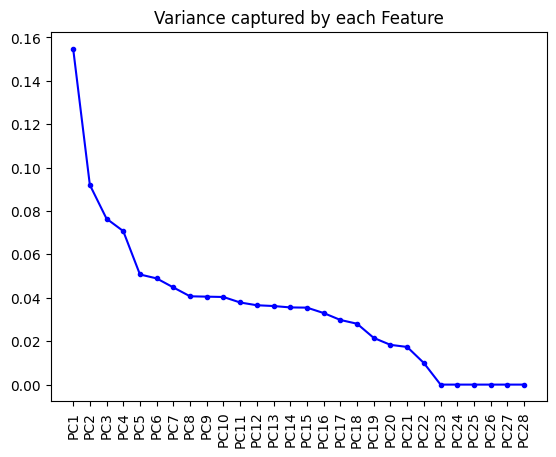

2024/12/19 23:38:57 INFO mlflow.tracking.fluent: Experiment with name 'Experiment_5' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/1291a81496d34d488f45401e22a5aa60', creation_time=1734669538690, experiment_id='3', last_update_time=1734669538690, lifecycle_stage='active', name='Experiment_5', tags={}>

{1: 0.1549,
 2: 0.2469,
 3: 0.3234,
 4: 0.3942,
 5: 0.4449,
 6: 0.4939,
 7: 0.5387,
 8: 0.5794,
 9: 0.6199,
 10: 0.6603,
 11: 0.6981,
 12: 0.7347,
 13: 0.7709,
 14: 0.8065,
 15: 0.842,
 16: 0.875,
 17: 0.9048,
 18: 0.9328,
 19: 0.9544,
 20: 0.9727,
 21: 0.99,
 22: 1.0,
 23: 1.0,
 24: 1.0,
 25: 1.0,
 26: 1.0,
 27: 1.0,
 28: 1.0}

🏃 View run PCA at: https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow/#/experiments/3/runs/d9954a16a01445bc8c65e7e360eddbb3
🧪 View experiment at: https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow/#/experiments/3


In [ ]:
num_attribs = ["age", "work_experience"]
cat_attribs = ["gender", "ever_married", "graduated", "profession", "spending_score", "var_1"]


cat_pipeline = Pipeline([
    ("onehotencoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessing = ColumnTransformer([
    ("family_size",family_size_pipeline,["family_size"]),
    ("cat", cat_pipeline, cat_attribs),
    ("num", num_pipeline, num_attribs),
    
])
customer_segment_prepared = preprocessing.fit_transform(customer_segment)

num_feature_names = [f"{attr}" for attr in num_attribs]  # Example: ['age_log', 'work_experience_log', ...]

# For categorical attributes (OneHotEncoder), get the feature names
cat_feature_names = preprocessing.transformers_[1][1].named_steps['onehotencoder'].get_feature_names_out(cat_attribs)

# Combine both numerical and categorical feature names
all_feature_names = np.concatenate([["family_size"],num_feature_names, cat_feature_names])

customer_segment_prepared = preprocessing.fit_transform(customer_segment)


num_feature_names = num_attribs

# For categorical attributes (OneHotEncoder), get the feature names
cat_feature_names = preprocessing.transformers_[1][1].named_steps['onehotencoder'].get_feature_names_out(cat_attribs)

# Combine both numerical and categorical feature names
all_feature_names = np.concatenate([["family_size"],num_feature_names, cat_feature_names])

customer_segment_prepared_fr = pd.DataFrame(
    customer_segment_prepared,
    columns=all_feature_names,
    index=customer_segment.index)

from sklearn.decomposition import PCA

descriptors = customer_segment_prepared_fr.columns
scaling = StandardScaler()
scaling.fit(customer_segment_prepared_fr)
df_feature_scaled = scaling.transform(customer_segment_prepared_fr)
pca = PCA(n_components= 28)
pca.fit(df_feature_scaled)
var_ratio = pca.explained_variance_ratio_
df_pca_features = pd.DataFrame(pca.fit_transform(df_feature_scaled))

componenet = pca.components_
df_pca_features.set_index(customer_segment_prepared_fr.index, inplace = True)
df_pca_features.head()

sum = 0
captured = {}
for var, idx in zip(var_ratio, range(1,29) ):
    sum = sum+ var
    captured[idx] = float(round(sum, 4))

print(captured)


plt.figure()
x = ["PC" + str(ele) for ele in range(1,29)]
plt.plot(x, var_ratio, '.b-')
plt.title("Variance captured by each Feature")
plt.xticks(rotation=90)
plt.show()

scree_plot_path = "scree_plot.png"
plt.savefig(scree_plot_path)
plt.close() 



MLFLOW_TRACKING_URI="https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME']='Jyothismaria'
os.environ['MLFLOW_TRACKING_PASSWORD']='23ccfad0cc03f842ff9abd620ab983625766bd42'


import mlflow
from mlflow.models import infer_signature

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)

# Create a new MLflow Experiment
mlflow.set_experiment("Experiment_5")


with mlflow.start_run(run_name="PCA"):
    mlflow.log_artifact(scree_plot_path, artifact_path="scree_plot")
    mlflow.log_param("captured variance cumulative", captured )


    

os.remove(scree_plot_path)


In [ ]:
model =  XGBClassifier(random_state=42)
pipeline = Pipeline([
    ('preprocessing', preprocessing),   
    ('pca', PCA(n_components=18)),  
    ('classifier', model)  
])

scoring = {
    "f1": make_scorer(f1_score, average="weighted"),
    "accuracy": "accuracy",
    "precision": "precision_weighted",
    "recall": "recall_weighted"
}

param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'classifier__subsample': [0.6, 0.8, 1.0]
}

search = GridSearchCV(pipeline, param_grid, scoring="f1_weighted", cv=3, n_jobs=-1)
search.fit(customer_segment, y_train)

# Log cross-validation results
cv_results = cross_validate(search.best_estimator_, customer_segment, y_train, scoring=scoring, cv=10, return_train_score=True)
mean_cv_f1 = np.mean(cv_results["test_f1"])
std_cv_f1 = np.std(cv_results["test_f1"])


best_pipeline = search.best_estimator_
best_pipeline.fit(customer_segment, y_train)
y_pred = best_pipeline.predict(X_test)


f1 = f1_score(y_test, y_pred, average="weighted")
cm = confusion_matrix(y_test, y_pred)
classes = [0, 1, 2, 3]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Save plot to a temporary file
cm_plot_path = "confusion_matrix.png"
plt.savefig(cm_plot_path)
plt.close()  # Close the figure to avoid display issues

metrics = {}

for i, label in enumerate(classes):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    tn = cm.sum() - (tp + fp + fn)
    metrics[label] = {
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn,
    }


MLFLOW_TRACKING_URI="https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME']='Jyothismaria'
os.environ['MLFLOW_TRACKING_PASSWORD']='23ccfad0cc03f842ff9abd620ab983625766bd42'


import mlflow
from mlflow.models import infer_signature

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)

# Create a new MLflow Experiment
mlflow.set_experiment("Experiment_5")

score = -search.best_score_
params = search.best_params_
with mlflow.start_run(run_name="xgb"):
    mlflow.log_param("best_params", search.best_params_)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("mean_cv_f1", mean_cv_f1)
    mlflow.log_metric("std_cv_f1", std_cv_f1)
    # Log the confusion matrix plot as an artifact
    mlflow.log_artifact(cm_plot_path, artifact_path="confusion_matrix")

    # Optionally, log metrics or other details
    for label, metric in metrics.items():
        for metric_name, value in metric.items():
            mlflow.log_metric(f"{label}_{metric_name}", value)
    mlflow.sklearn.log_model(best_pipeline, "xgb_classifier_pipeline")

os.remove(cm_plot_path)

c:\Users\jyoth\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('family_size',
                                                                         Pipeline(steps=[('log_transform',
                                                                                          FunctionTransformer(func=<function log_transform at 0x00000228218484A0>,
                                                                                                              validate=True)),
                                                                                         ('standardize',
                                                                                          StandardScaler())]),
                                                                         ['family_size']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ig...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.01, 0.1, 0.2, 0.3],
                         'classifier__max_depth': [3, 5, 7, 10],
                         'classifier__n_estimators': [50, 100, 200],
                         'classifier__subsample': [0.6, 0.8, 1.0]},
             scoring='f1_weighted')

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('family_size',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<function log_transform at 0x00000228218484A0>,
                                                                                       validate=True)),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  ['family_size']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'ever_ma...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 36.72222222222221, 'Predicted Labels')

Text(70.72222222222221, 0.5, 'True Labels')

Text(0.5, 1.0, 'Confusion Matrix')

<Experiment: artifact_location='mlflow-artifacts:/1291a81496d34d488f45401e22a5aa60', creation_time=1734669538690, experiment_id='3', last_update_time=1734669538690, lifecycle_stage='active', name='Experiment_5', tags={}>

{'classifier__learning_rate': 0.1,
 'classifier__max_depth': 3,
 'classifier__n_estimators': 100,
 'classifier__subsample': 0.6}

2024/12/19 23:46:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run xgb at: https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow/#/experiments/3/runs/a9965c2643304900b7067e836d3894bc
🧪 View experiment at: https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow/#/experiments/3


In [ ]:
model =  RandomForestClassifier(random_state=42)

pipeline = Pipeline([
    ('preprocessing', preprocessing),   
    ('pca', PCA(n_components=18)),  
    ('classifier', model)  
])

scoring = {
    "f1": make_scorer(f1_score, average="weighted"),
    "accuracy": "accuracy",
    "precision": "precision_weighted",
    "recall": "recall_weighted"
}


param_grid = {
    "classifier__criterion": ["gini","entropy","log_loss"],  
}

search = GridSearchCV(pipeline, param_grid, scoring="f1_weighted", cv=3, n_jobs=-1)
search.fit(customer_segment, y_train)


cv_results = cross_validate(search.best_estimator_, customer_segment, y_train, scoring=scoring, cv=10, return_train_score=True)
mean_cv_f1 = np.mean(cv_results["test_f1"])
std_cv_f1 = np.std(cv_results["test_f1"])


best_pipeline = search.best_estimator_
best_pipeline.fit(customer_segment, y_train)
y_pred = best_pipeline.predict(X_test)


f1 = f1_score(y_test, y_pred, average="weighted")
cm = confusion_matrix(y_test, y_pred)
classes = [0, 1, 2, 3]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Save plot to a temporary file
cm_plot_path = "confusion_matrix.png"
plt.savefig(cm_plot_path)
plt.close()  

metrics = {}

for i, label in enumerate(classes):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    tn = cm.sum() - (tp + fp + fn)
    metrics[label] = {
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn,
    }


MLFLOW_TRACKING_URI="https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME']='Jyothismaria'
os.environ['MLFLOW_TRACKING_PASSWORD']='23ccfad0cc03f842ff9abd620ab983625766bd42'


import mlflow
from mlflow.models import infer_signature

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)

# Create a new MLflow Experiment
mlflow.set_experiment("Experiment_5")

score = -search.best_score_
params = search.best_params_
with mlflow.start_run(run_name="rf"):
    mlflow.log_param("best_params", search.best_params_)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("mean_cv_f1", mean_cv_f1)
    mlflow.log_metric("std_cv_f1", std_cv_f1)

    mlflow.log_artifact(cm_plot_path, artifact_path="confusion_matrix")

    for label, metric in metrics.items():
        for metric_name, value in metric.items():
            mlflow.log_metric(f"{label}_{metric_name}", value)
    mlflow.sklearn.log_model(best_pipeline, "rf_classifier_pipeline")

os.remove(cm_plot_path)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('family_size',
                                                                         Pipeline(steps=[('log_transform',
                                                                                          FunctionTransformer(func=<function log_transform at 0x00000228218484A0>,
                                                                                                              validate=True)),
                                                                                         ('standardize',
                                                                                          StandardScaler())]),
                                                                         ['family_size']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ig...
                                                                         ['gender',
                                                                          'ever_married',
                                                                          'graduated',
                                                                          'profession',
                                                                          'spending_score',
                                                                          'var_1']),
                                                                        ('num',
                                                                         Pipeline(steps=[('standardize',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'work_experience'])])),
                                       ('pca', PCA(n_components=18)),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__criterion': ['gini', 'entropy',
                                                   'log_loss']},
             scoring='f1_weighted')

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('family_size',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<function log_transform at 0x00000228218484A0>,
                                                                                       validate=True)),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  ['family_size']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'ever_married',
                                                   'graduated', 'profession',
                                                   'spending_score', 'var_1']),
                                                 ('num',
                                                  Pipeline(steps=[('standardize',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'work_experience'])])),
                ('pca', PCA(n_components=18)),
                ('classifier', RandomForestClassifier(random_state=42))])

<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 36.72222222222221, 'Predicted Labels')

Text(70.72222222222221, 0.5, 'True Labels')

Text(0.5, 1.0, 'Confusion Matrix')

<Experiment: artifact_location='mlflow-artifacts:/1291a81496d34d488f45401e22a5aa60', creation_time=1734669538690, experiment_id='3', last_update_time=1734669538690, lifecycle_stage='active', name='Experiment_5', tags={}>

{'classifier__criterion': 'gini'}

2024/12/19 23:47:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run rf at: https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow/#/experiments/3/runs/f98287f5b3ea4160ab73826c5c3a04f9
🧪 View experiment at: https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow/#/experiments/3


In [ ]:

model =  RidgeClassifier(random_state=42)


pipeline = Pipeline([
    ('preprocessing', preprocessing),   
    ('pca', PCA(n_components=18)),  
    ('classifier', model)  
])

scoring = {
    "f1": make_scorer(f1_score, average="weighted"),
    "accuracy": "accuracy",
    "precision": "precision_weighted",
    "recall": "recall_weighted"
}

  
param_grid = {
    "classifier__alpha": range(1, 100, 10),  # Regularization strength
    "classifier__solver": ["auto", "svd", "cholesky", "lsqr", "sag", "saga"],  # Valid solvers for RidgeClassifier
    "classifier__fit_intercept": [True, False]  # Whether to calculate the intercept
}

search = GridSearchCV(pipeline, param_grid, scoring="f1_weighted", cv=3, n_jobs=-1)
search.fit(customer_segment, y_train)

# Log cross-validation results
cv_results = cross_validate(search.best_estimator_, customer_segment, y_train, scoring=scoring, cv=10, return_train_score=True)
mean_cv_f1 = np.mean(cv_results["test_f1"])
std_cv_f1 = np.std(cv_results["test_f1"])

# Step 8: Train the model on the whole training data
best_pipeline = search.best_estimator_
best_pipeline.fit(customer_segment, y_train)
y_pred = best_pipeline.predict(X_test)

# Step 9: Calculate metrics on test data
f1 = f1_score(y_test, y_pred, average="weighted")
cm = confusion_matrix(y_test, y_pred)
classes = [0, 1, 2, 3]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Save plot to a temporary file
cm_plot_path = "confusion_matrix.png"
plt.savefig(cm_plot_path)
plt.close()  # Close the figure to avoid display issues

metrics = {}

for i, label in enumerate(classes):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    tn = cm.sum() - (tp + fp + fn)
    metrics[label] = {
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn,
    }


MLFLOW_TRACKING_URI="https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME']='Jyothismaria'
os.environ['MLFLOW_TRACKING_PASSWORD']='23ccfad0cc03f842ff9abd620ab983625766bd42'


import mlflow
from mlflow.models import infer_signature

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)

# Create a new MLflow Experiment
mlflow.set_experiment("Experiment_5")

score = -search.best_score_
params = search.best_params_
with mlflow.start_run(run_name="ridge"):
    mlflow.log_param("best_params", search.best_params_)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("mean_cv_f1", mean_cv_f1)
    mlflow.log_metric("std_cv_f1", std_cv_f1)
    # Log the confusion matrix plot as an artifact
    mlflow.log_artifact(cm_plot_path, artifact_path="confusion_matrix")

    # Optionally, log metrics or other details
    for label, metric in metrics.items():
        for metric_name, value in metric.items():
            mlflow.log_metric(f"{label}_{metric_name}", value)
    mlflow.sklearn.log_model(best_pipeline, "ridge_classifier_pipeline")

os.remove(cm_plot_path)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('family_size',
                                                                         Pipeline(steps=[('log_transform',
                                                                                          FunctionTransformer(func=<function log_transform at 0x00000228218484A0>,
                                                                                                              validate=True)),
                                                                                         ('standardize',
                                                                                          StandardScaler())]),
                                                                         ['family_size']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ig...
                                                                        ('num',
                                                                         Pipeline(steps=[('standardize',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'work_experience'])])),
                                       ('pca', PCA(n_components=18)),
                                       ('classifier',
                                        RidgeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__alpha': range(1, 100, 10),
                         'classifier__fit_intercept': [True, False],
                         'classifier__solver': ['auto', 'svd', 'cholesky',
                                                'lsqr', 'sag', 'saga']},
             scoring='f1_weighted')

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('family_size',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<function log_transform at 0x00000228218484A0>,
                                                                                       validate=True)),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  ['family_size']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'ever_married',
                                                   'graduated', 'profession',
                                                   'spending_score', 'var_1']),
                                                 ('num',
                                                  Pipeline(steps=[('standardize',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'work_experience'])])),
                ('pca', PCA(n_components=18)),
                ('classifier',
                 RidgeClassifier(alpha=31, fit_intercept=False, random_state=42,
                                 solver='sag'))])

<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 36.72222222222221, 'Predicted Labels')

Text(70.72222222222221, 0.5, 'True Labels')

Text(0.5, 1.0, 'Confusion Matrix')

<Experiment: artifact_location='mlflow-artifacts:/1291a81496d34d488f45401e22a5aa60', creation_time=1734669538690, experiment_id='3', last_update_time=1734669538690, lifecycle_stage='active', name='Experiment_5', tags={}>

{'classifier__alpha': 31,
 'classifier__fit_intercept': False,
 'classifier__solver': 'sag'}

2024/12/19 23:43:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run ridge at: https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow/#/experiments/3/runs/fcc810ac0d2741d98ea5c2972ec5f9a6
🧪 View experiment at: https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow/#/experiments/3


In [ ]:

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, classification_report
import os
model = LogisticRegression(max_iter=1000, random_state=42)


pipeline = Pipeline([
    ('preprocessing', preprocessing),   
    ('pca', PCA(n_components=18)),  
    ('classifier', model)  
])

scoring = {
    "f1": make_scorer(f1_score, average="weighted"),
    "accuracy": "accuracy",
    "precision": "precision_weighted",
    "recall": "recall_weighted"
}

  
param_grid = {
    "classifier__C": [0.01, 0.1, 1, 10, 100],
    "classifier__solver": ["lbfgs", "liblinear"]
}

search = GridSearchCV(pipeline, param_grid, scoring="f1_weighted", cv=3, n_jobs=-1)
search.fit(customer_segment, y_train)

# Log cross-validation results
cv_results = cross_validate(search.best_estimator_, customer_segment, y_train, scoring=scoring, cv=10, return_train_score=True)
mean_cv_f1 = np.mean(cv_results["test_f1"])
std_cv_f1 = np.std(cv_results["test_f1"])

# Step 8: Train the model on the whole training data
best_pipeline = search.best_estimator_
best_pipeline.fit(customer_segment, y_train)
y_pred = best_pipeline.predict(X_test)

# Step 9: Calculate metrics on test data
f1 = f1_score(y_test, y_pred, average="weighted")

cm = confusion_matrix(y_test, y_pred)
classes = [0, 1, 2, 3]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Save plot to a temporary file
cm_plot_path = "confusion_matrix.png"
plt.savefig(cm_plot_path)
plt.close()  # Close the figure to avoid display issues

metrics = {}

for i, label in enumerate(classes):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    tn = cm.sum() - (tp + fp + fn)
    metrics[label] = {
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn,
    }


MLFLOW_TRACKING_URI="https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME']='Jyothismaria'
os.environ['MLFLOW_TRACKING_PASSWORD']='23ccfad0cc03f842ff9abd620ab983625766bd42'


import mlflow
from mlflow.models import infer_signature

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)

# Create a new MLflow Experiment
mlflow.set_experiment("Experiment_5")

score = -search.best_score_
params = search.best_params_
with mlflow.start_run(run_name="logr"):
    mlflow.log_param("best_params", search.best_params_)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("mean_cv_f1", mean_cv_f1)
    mlflow.log_metric("std_cv_f1", std_cv_f1)
    # Log the confusion matrix plot as an artifact
    mlflow.log_artifact(cm_plot_path, artifact_path="confusion_matrix")

    # Optionally, log metrics or other details
    for label, metric in metrics.items():
        for metric_name, value in metric.items():
            mlflow.log_metric(f"{label}_{metric_name}", value)
    mlflow.sklearn.log_model(best_pipeline, "logistic_regression_pipeline")

os.remove(cm_plot_path)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('family_size',
                                                                         Pipeline(steps=[('log_transform',
                                                                                          FunctionTransformer(func=<function log_transform at 0x00000228218484A0>,
                                                                                                              validate=True)),
                                                                                         ('standardize',
                                                                                          StandardScaler())]),
                                                                         ['family_size']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ig...
                                                                          'graduated',
                                                                          'profession',
                                                                          'spending_score',
                                                                          'var_1']),
                                                                        ('num',
                                                                         Pipeline(steps=[('standardize',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'work_experience'])])),
                                       ('pca', PCA(n_components=18)),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.01, 0.1, 1, 10, 100],
                         'classifier__solver': ['lbfgs', 'liblinear']},
             scoring='f1_weighted')

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('family_size',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<function log_transform at 0x00000228218484A0>,
                                                                                       validate=True)),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  ['family_size']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'ever_married',
                                                   'graduated', 'profession',
                                                   'spending_score', 'var_1']),
                                                 ('num',
                                                  Pipeline(steps=[('standardize',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'work_experience'])])),
                ('pca', PCA(n_components=18)),
                ('classifier',
                 LogisticRegression(C=10, max_iter=1000, random_state=42))])

<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 36.72222222222221, 'Predicted Labels')

Text(70.72222222222221, 0.5, 'True Labels')

Text(0.5, 1.0, 'Confusion Matrix')

<Experiment: artifact_location='mlflow-artifacts:/1291a81496d34d488f45401e22a5aa60', creation_time=1734669538690, experiment_id='3', last_update_time=1734669538690, lifecycle_stage='active', name='Experiment_5', tags={}>

{'classifier__C': 10, 'classifier__solver': 'lbfgs'}

2024/12/19 23:42:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run logr at: https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow/#/experiments/3/runs/b5af48508bf3413d86c6ccd424fbdd2a
🧪 View experiment at: https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow/#/experiments/3


## Experiment 6 <br>  
instead of just one hot encoding adding ordinal encoding for spending_score <br>  
removing gender since the model will be biased based on gender of customer

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("standardize", StandardScaler()),
])

num_pipeline

def log_transform(x):
    return np.log1p(x)

family_size_pipeline = Pipeline([
    ("log_transform", FunctionTransformer(log_transform, validate=True)),
    ("standardize", StandardScaler())
])

num_attribs = ["age", "work_experience"]
cat_attribs = ["ever_married", "graduated", "profession", "var_1"]
ordinal_attribs = ["spending_score"]


cat_pipeline = Pipeline([
    ("onehotencoder", OneHotEncoder(handle_unknown="ignore"))
])

spending_pipeline = Pipeline([
    ("ordinalencoder", OrdinalEncoder())
])

class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        return self  # Nothing to learn

    def transform(self, X):
        # Drop specified columns and ensure correct shape
        return X.drop(columns=self.columns_to_drop, axis=1)
    
preprocessing = ColumnTransformer([
    ('drop_columns', ColumnDropper(columns_to_drop=['gender']),["gender"] ),  # Drop 'gender' column
    ("family_size", family_size_pipeline, ["family_size"]),
    ("cat", cat_pipeline, cat_attribs),
    ('spending_score', spending_pipeline, ordinal_attribs),
    ("num", num_pipeline, num_attribs),
])

customer_segment_prepared = preprocessing.fit_transform(customer_segment)


num_feature_names = num_attribs

# For categorical attributes (OneHotEncoder), get the feature names
cat_feature_names = preprocessing.transformers_[2][1].named_steps['onehotencoder'].get_feature_names_out(cat_attribs)
print(f"Number of one-hot encoded columns: {len(cat_feature_names)}")
print(f"Feature names from OneHotEncoder: {cat_feature_names}")

# Combine both numerical and categorical feature names
all_feature_names = np.concatenate([["family_size"],cat_feature_names,["spending_score"],num_feature_names ])

customer_segment_prepared_fr = pd.DataFrame(
    customer_segment_prepared,
    columns=all_feature_names,
    index=customer_segment.index)
customer_segment_prepared_fr

Pipeline(steps=[('standardize', StandardScaler())])

Number of one-hot encoded columns: 20
Feature names from OneHotEncoder: ['ever_married_No' 'ever_married_Yes' 'graduated_No' 'graduated_Yes'
 'profession_Artist' 'profession_Doctor' 'profession_Engineer'
 'profession_Entertainment' 'profession_Executive' 'profession_Healthcare'
 'profession_Homemaker' 'profession_Lawyer' 'profession_Marketing'
 'var_1_0' 'var_1_1' 'var_1_2' 'var_1_3' 'var_1_4' 'var_1_5' 'var_1_6']


family_size  ever_married_No  ever_married_Yes  graduated_No  \
customerid                                                                 
464859         0.309238              0.0               1.0           0.0   
461353         0.895748              0.0               1.0           0.0   
467313        -0.446903              0.0               1.0           0.0   
466952        -0.446903              0.0               1.0           0.0   
465687        -1.512626              0.0               1.0           0.0   
...                 ...              ...               ...           ...   
467906         1.374961              1.0               0.0           1.0   
465445         2.131102              1.0               0.0           0.0   
459438        -0.446903              0.0               1.0           0.0   
463754         0.895748              1.0               0.0           0.0   
467249        -1.512626              1.0               0.0           0.0   

            graduated_Yes  profession_Artist  profession_Doctor  \
customerid                                                        
464859                1.0                1.0                0.0   
461353                1.0                0.0                0.0   
467313                1.0                0.0                0.0   
466952                1.0                1.0                0.0   
465687                1.0                0.0                0.0   
...                   ...                ...                ...   
467906                0.0                0.0                0.0   
465445                1.0                0.0                0.0   
459438                1.0                1.0                0.0   
463754                1.0                0.0                0.0   
467249                1.0                0.0                0.0   

            profession_Engineer  profession_Entertainment  \
customerid                                                  
464859                      0.0                       0.0   
461353                      0.0                       0.0   
467313                      0.0                       1.0   
466952                      0.0                       0.0   
465687                      0.0                       0.0   
...                         ...                       ...   
467906                      0.0                       0.0   
465445                      0.0                       0.0   
459438                      0.0                       0.0   
463754                      0.0                       1.0   
467249                      0.0                       0.0   

            profession_Executive  ...  var_1_0  var_1_1  var_1_2  var_1_3  \
customerid                        ...                                       
464859                       0.0  ...      0.0      1.0      0.0      0.0   
461353                       1.0  ...      0.0      1.0      0.0      0.0   
467313                       0.0  ...      0.0      1.0      0.0      0.0   
466952                       0.0  ...      0.0      1.0      0.0      0.0   
465687                       0.0  ...      0.0      1.0      0.0      0.0   
...                          ...  ...      ...      ...      ...      ...   
467906                       0.0  ...      0.0      0.0      0.0      0.0   
465445                       0.0  ...      0.0      1.0      0.0      0.0   
459438                       0.0  ...      0.0      1.0      0.0      0.0   
463754                       0.0  ...      0.0      0.0      0.0      0.0   
467249                       0.0  ...      0.0      1.0      0.0      0.0   

            var_1_4  var_1_5  var_1_6  spending_score       age  \
customerid                                                        
464859          0.0      0.0      0.0             0.0  0.084290   
461353          0.0      0.0      0.0             1.0  0.387839   
467313          0.0      0.0      0.0             0.0 -0.279969   
466952          0.0 

In [ ]:
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, classification_report
import os
model = LogisticRegression(max_iter=1000, random_state=42)


pipeline = Pipeline([
    ("preprocessor", preprocessing),
    ("classifier", model)
])

scoring = {
    "f1": make_scorer(f1_score, average="weighted"),
    "accuracy": "accuracy",
    "precision": "precision_weighted",
    "recall": "recall_weighted"
}

  
param_grid = {
    "classifier__C": [0.01, 0.1, 1, 10, 100],
    "classifier__solver": ["lbfgs", "liblinear"]
}

search = GridSearchCV(pipeline, param_grid, scoring="f1_weighted", cv=3, n_jobs=-1)
search.fit(customer_segment, y_train)

# Log cross-validation results
cv_results = cross_validate(search.best_estimator_, customer_segment, y_train, scoring=scoring, cv=10, return_train_score=True)
mean_cv_f1 = np.mean(cv_results["test_f1"])
std_cv_f1 = np.std(cv_results["test_f1"])

# Step 8: Train the model on the whole training data
best_pipeline = search.best_estimator_
best_pipeline.fit(customer_segment, y_train)
y_pred = best_pipeline.predict(X_test)

# Step 9: Calculate metrics on test data
f1 = f1_score(y_test, y_pred, average="weighted")

cm = confusion_matrix(y_test, y_pred)
classes = [0, 1, 2, 3]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Save plot to a temporary file
cm_plot_path = "confusion_matrix.png"
plt.savefig(cm_plot_path)
plt.close()  # Close the figure to avoid display issues

metrics = {}

for i, label in enumerate(classes):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    tn = cm.sum() - (tp + fp + fn)
    metrics[label] = {
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn,
    }


MLFLOW_TRACKING_URI="https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME']='Jyothismaria'
os.environ['MLFLOW_TRACKING_PASSWORD']='23ccfad0cc03f842ff9abd620ab983625766bd42'


import mlflow
from mlflow.models import infer_signature

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)

# Create a new MLflow Experiment
mlflow.set_experiment("experiment_6")

score = -search.best_score_
params = search.best_params_
with mlflow.start_run(run_name="ordinal_logr"):
    mlflow.log_param("best_params", search.best_params_)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("mean_cv_f1", mean_cv_f1)
    mlflow.log_metric("std_cv_f1", std_cv_f1)
    # Log the confusion matrix plot as an artifact
    mlflow.log_artifact(cm_plot_path, artifact_path="confusion_matrix")

    # Optionally, log metrics or other details
    for label, metric in metrics.items():
        for metric_name, value in metric.items():
            mlflow.log_metric(f"{label}_{metric_name}", value)
    mlflow.sklearn.log_model(best_pipeline, "logistic_regression_pipeline")

os.remove(cm_plot_path)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('drop_columns',
                                                                         ColumnDropper(columns_to_drop=['gender']),
                                                                         ['gender']),
                                                                        ('family_size',
                                                                         Pipeline(steps=[('log_transform',
                                                                                          FunctionTransformer(func=<function log_transform at 0x000002283585FCE0>,
                                                                                                              validate=True)),
                                                                                         ('standardize',
                                                                                          StandardScaler())]),
                                                                         ['family_size']),
                                                                        ('c...
                                                                         Pipeline(steps=[('ordinalencoder',
                                                                                          OrdinalEncoder())]),
                                                                         ['spending_score']),
                                                                        ('num',
                                                                         Pipeline(steps=[('standardize',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'work_experience'])])),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.01, 0.1, 1, 10, 100],
                         'classifier__solver': ['lbfgs', 'liblinear']},
             scoring='f1_weighted')

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('drop_columns',
                                                  ColumnDropper(columns_to_drop=['gender']),
                                                  ['gender']),
                                                 ('family_size',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<function log_transform at 0x000002283585FCE0>,
                                                                                       validate=True)),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  ['family_size']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ever_married', 'graduated',
                                                   'profession', 'var_1']),
                                                 ('spending_score',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder())]),
                                                  ['spending_score']),
                                                 ('num',
                                                  Pipeline(steps=[('standardize',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'work_experience'])])),
                ('classifier',
                 LogisticRegression(C=1, max_iter=1000, random_state=42))])

<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 36.72222222222221, 'Predicted Labels')

Text(70.72222222222221, 0.5, 'True Labels')

Text(0.5, 1.0, 'Confusion Matrix')

<Experiment: artifact_location='mlflow-artifacts:/f8607cfe4af540869fcb04934309697f', creation_time=1734668206709, experiment_id='2', last_update_time=1734668206709, lifecycle_stage='active', name='experiment_6', tags={}>

{'classifier__C': 1, 'classifier__solver': 'lbfgs'}

2024/12/20 00:13:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run ordinal_logr at: https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow/#/experiments/2/runs/259fa52ad40b403abd404b08467ab899
🧪 View experiment at: https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow/#/experiments/2


In [ ]:

model =  RidgeClassifier(random_state=42)


pipeline = Pipeline([
    ("preprocessor", preprocessing),
    ("classifier", model)
])

scoring = {
    "f1": make_scorer(f1_score, average="weighted"),
    "accuracy": "accuracy",
    "precision": "precision_weighted",
    "recall": "recall_weighted"
}

  
param_grid = {
    "classifier__alpha": range(1, 100, 10),  # Regularization strength
    "classifier__solver": ["auto", "svd", "cholesky", "lsqr", "sag", "saga"],  # Valid solvers for RidgeClassifier
    "classifier__fit_intercept": [True, False]  # Whether to calculate the intercept
}

search = GridSearchCV(pipeline, param_grid, scoring="f1_weighted", cv=3, n_jobs=-1)
search.fit(customer_segment, y_train)

# Log cross-validation results
cv_results = cross_validate(search.best_estimator_, customer_segment, y_train, scoring=scoring, cv=10, return_train_score=True)
mean_cv_f1 = np.mean(cv_results["test_f1"])
std_cv_f1 = np.std(cv_results["test_f1"])

# Step 8: Train the model on the whole training data
best_pipeline = search.best_estimator_
best_pipeline.fit(customer_segment, y_train)
y_pred = best_pipeline.predict(X_test)

# Step 9: Calculate metrics on test data
f1 = f1_score(y_test, y_pred, average="weighted")
cm = confusion_matrix(y_test, y_pred)
classes = [0, 1, 2, 3]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Save plot to a temporary file
cm_plot_path = "confusion_matrix.png"
plt.savefig(cm_plot_path)
plt.close()  # Close the figure to avoid display issues

metrics = {}

for i, label in enumerate(classes):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    tn = cm.sum() - (tp + fp + fn)
    metrics[label] = {
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn,
    }


MLFLOW_TRACKING_URI="https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME']='Jyothismaria'
os.environ['MLFLOW_TRACKING_PASSWORD']='23ccfad0cc03f842ff9abd620ab983625766bd42'


import mlflow
from mlflow.models import infer_signature

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)

# Create a new MLflow Experiment
mlflow.set_experiment("experiment_6")

score = -search.best_score_
params = search.best_params_
with mlflow.start_run(run_name="ridge"):
    mlflow.log_param("best_params", search.best_params_)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("mean_cv_f1", mean_cv_f1)
    mlflow.log_metric("std_cv_f1", std_cv_f1)
    # Log the confusion matrix plot as an artifact
    mlflow.log_artifact(cm_plot_path, artifact_path="confusion_matrix")

    # Optionally, log metrics or other details
    for label, metric in metrics.items():
        for metric_name, value in metric.items():
            mlflow.log_metric(f"{label}_{metric_name}", value)
    mlflow.sklearn.log_model(best_pipeline, "ridge_classifier_pipeline")

os.remove(cm_plot_path)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('drop_columns',
                                                                         ColumnDropper(columns_to_drop=['gender']),
                                                                         ['gender']),
                                                                        ('family_size',
                                                                         Pipeline(steps=[('log_transform',
                                                                                          FunctionTransformer(func=<function log_transform at 0x000002283585FCE0>,
                                                                                                              validate=True)),
                                                                                         ('standardize',
                                                                                          StandardScaler())]),
                                                                         ['family_size']),
                                                                        ('c...
                                                                                          OrdinalEncoder())]),
                                                                         ['spending_score']),
                                                                        ('num',
                                                                         Pipeline(steps=[('standardize',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'work_experience'])])),
                                       ('classifier',
                                        RidgeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__alpha': range(1, 100, 10),
                         'classifier__fit_intercept': [True, False],
                         'classifier__solver': ['auto', 'svd', 'cholesky',
                                                'lsqr', 'sag', 'saga']},
             scoring='f1_weighted')

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('drop_columns',
                                                  ColumnDropper(columns_to_drop=['gender']),
                                                  ['gender']),
                                                 ('family_size',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<function log_transform at 0x000002283585FCE0>,
                                                                                       validate=True)),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  ['family_size']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot...
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ever_married', 'graduated',
                                                   'profession', 'var_1']),
                                                 ('spending_score',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder())]),
                                                  ['spending_score']),
                                                 ('num',
                                                  Pipeline(steps=[('standardize',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'work_experience'])])),
                ('classifier',
                 RidgeClassifier(alpha=1, fit_intercept=False, random_state=42,
                                 solver='lsqr'))])

<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 36.72222222222221, 'Predicted Labels')

Text(70.72222222222221, 0.5, 'True Labels')

Text(0.5, 1.0, 'Confusion Matrix')

<Experiment: artifact_location='mlflow-artifacts:/f8607cfe4af540869fcb04934309697f', creation_time=1734668206709, experiment_id='2', last_update_time=1734668206709, lifecycle_stage='active', name='experiment_6', tags={}>

{'classifier__alpha': 1,
 'classifier__fit_intercept': False,
 'classifier__solver': 'lsqr'}

2024/12/20 00:13:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run ridge at: https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow/#/experiments/2/runs/60fbd52abed54dbfbbeb1dd81b672e59
🧪 View experiment at: https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow/#/experiments/2


In [ ]:
model =  RandomForestClassifier(random_state=42)


pipeline = Pipeline([
    ("preprocessor", preprocessing),
    ("classifier", model)
])

scoring = {
    "f1": make_scorer(f1_score, average="weighted"),
    "accuracy": "accuracy",
    "precision": "precision_weighted",
    "recall": "recall_weighted"
}

# Step 7: Cross-validation and hyperparameter tuning
param_grid = {
    "classifier__criterion": ["gini","entropy","log_loss"],  # Regularization strength
}

search = GridSearchCV(pipeline, param_grid, scoring="f1_weighted", cv=3, n_jobs=-1)
search.fit(customer_segment, y_train)

# Log cross-validation results
cv_results = cross_validate(search.best_estimator_, customer_segment, y_train, scoring=scoring, cv=10, return_train_score=True)
mean_cv_f1 = np.mean(cv_results["test_f1"])
std_cv_f1 = np.std(cv_results["test_f1"])

# Step 8: Train the model on the whole training data
best_pipeline = search.best_estimator_
best_pipeline.fit(customer_segment, y_train)
y_pred = best_pipeline.predict(X_test)

# Step 9: Calculate metrics on test data
f1 = f1_score(y_test, y_pred, average="weighted")
cm = confusion_matrix(y_test, y_pred)
classes = [0, 1, 2, 3]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Save plot to a temporary file
cm_plot_path = "confusion_matrix.png"
plt.savefig(cm_plot_path)
plt.close()  # Close the figure to avoid display issues

metrics = {}

for i, label in enumerate(classes):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    tn = cm.sum() - (tp + fp + fn)
    metrics[label] = {
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn,
    }


MLFLOW_TRACKING_URI="https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME']='Jyothismaria'
os.environ['MLFLOW_TRACKING_PASSWORD']='23ccfad0cc03f842ff9abd620ab983625766bd42'


import mlflow
from mlflow.models import infer_signature

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)

# Create a new MLflow Experiment
mlflow.set_experiment("experiment_6")

score = -search.best_score_
params = search.best_params_
with mlflow.start_run(run_name="rf"):
    mlflow.log_param("best_params", search.best_params_)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("mean_cv_f1", mean_cv_f1)
    mlflow.log_metric("std_cv_f1", std_cv_f1)
    # Log the confusion matrix plot as an artifact
    mlflow.log_artifact(cm_plot_path, artifact_path="confusion_matrix")

    # Optionally, log metrics or other details
    for label, metric in metrics.items():
        for metric_name, value in metric.items():
            mlflow.log_metric(f"{label}_{metric_name}", value)
    mlflow.sklearn.log_model(best_pipeline, "rf_classifier_pipeline")

os.remove(cm_plot_path)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('drop_columns',
                                                                         ColumnDropper(columns_to_drop=['gender']),
                                                                         ['gender']),
                                                                        ('family_size',
                                                                         Pipeline(steps=[('log_transform',
                                                                                          FunctionTransformer(func=<function log_transform at 0x000002283585FCE0>,
                                                                                                              validate=True)),
                                                                                         ('standardize',
                                                                                          StandardScaler())]),
                                                                         ['family_size']),
                                                                        ('c...
                                                                          'profession',
                                                                          'var_1']),
                                                                        ('spending_score',
                                                                         Pipeline(steps=[('ordinalencoder',
                                                                                          OrdinalEncoder())]),
                                                                         ['spending_score']),
                                                                        ('num',
                                                                         Pipeline(steps=[('standardize',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'work_experience'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__criterion': ['gini', 'entropy',
                                                   'log_loss']},
             scoring='f1_weighted')

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('drop_columns',
                                                  ColumnDropper(columns_to_drop=['gender']),
                                                  ['gender']),
                                                 ('family_size',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<function log_transform at 0x000002283585FCE0>,
                                                                                       validate=True)),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  ['family_size']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ever_married', 'graduated',
                                                   'profession', 'var_1']),
                                                 ('spending_score',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder())]),
                                                  ['spending_score']),
                                                 ('num',
                                                  Pipeline(steps=[('standardize',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'work_experience'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 36.72222222222221, 'Predicted Labels')

Text(70.72222222222221, 0.5, 'True Labels')

Text(0.5, 1.0, 'Confusion Matrix')

<Experiment: artifact_location='mlflow-artifacts:/f8607cfe4af540869fcb04934309697f', creation_time=1734668206709, experiment_id='2', last_update_time=1734668206709, lifecycle_stage='active', name='experiment_6', tags={}>

{'classifier__criterion': 'gini'}

2024/12/20 00:14:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run rf at: https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow/#/experiments/2/runs/3eb3283cd53742e197c2ab29aa07f96a
🧪 View experiment at: https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow/#/experiments/2


In [ ]:
model =  XGBClassifier(random_state=42)


pipeline = Pipeline([
    ("preprocessor", preprocessing),
    ("classifier", model)
])

scoring = {
    "f1": make_scorer(f1_score, average="weighted"),
    "accuracy": "accuracy",
    "precision": "precision_weighted",
    "recall": "recall_weighted"
}

param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'classifier__subsample': [0.6, 0.8, 1.0]
}

search = GridSearchCV(pipeline, param_grid, scoring="f1_weighted", cv=3, n_jobs=-1)
search.fit(customer_segment, y_train)

# Log cross-validation results
cv_results = cross_validate(search.best_estimator_, customer_segment, y_train, scoring=scoring, cv=10, return_train_score=True)
mean_cv_f1 = np.mean(cv_results["test_f1"])
std_cv_f1 = np.std(cv_results["test_f1"])


best_pipeline = search.best_estimator_
best_pipeline.fit(customer_segment, y_train)
y_pred = best_pipeline.predict(X_test)


f1 = f1_score(y_test, y_pred, average="weighted")
cm = confusion_matrix(y_test, y_pred)
classes = [0, 1, 2, 3]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Save plot to a temporary file
cm_plot_path = "confusion_matrix.png"
plt.savefig(cm_plot_path)
plt.close()  # Close the figure to avoid display issues

metrics = {}

for i, label in enumerate(classes):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    tn = cm.sum() - (tp + fp + fn)
    metrics[label] = {
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn,
    }


MLFLOW_TRACKING_URI="https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME']='Jyothismaria'
os.environ['MLFLOW_TRACKING_PASSWORD']='23ccfad0cc03f842ff9abd620ab983625766bd42'


import mlflow
from mlflow.models import infer_signature

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)

# Create a new MLflow Experiment
mlflow.set_experiment("experiment_6")

score = -search.best_score_
params = search.best_params_
with mlflow.start_run(run_name="xgb"):
    mlflow.log_param("best_params", search.best_params_)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("mean_cv_f1", mean_cv_f1)
    mlflow.log_metric("std_cv_f1", std_cv_f1)
    # Log the confusion matrix plot as an artifact
    mlflow.log_artifact(cm_plot_path, artifact_path="confusion_matrix")

    # Optionally, log metrics or other details
    for label, metric in metrics.items():
        for metric_name, value in metric.items():
            mlflow.log_metric(f"{label}_{metric_name}", value)
    mlflow.sklearn.log_model(best_pipeline, "xgb_classifier_pipeline")

os.remove(cm_plot_path)

c:\Users\jyoth\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('drop_columns',
                                                                         ColumnDropper(columns_to_drop=['gender']),
                                                                         ['gender']),
                                                                        ('family_size',
                                                                         Pipeline(steps=[('log_transform',
                                                                                          FunctionTransformer(func=<function log_transform at 0x000002283585FCE0>,
                                                                                                              validate=True)),
                                                                                         ('standardize',
                                                                                          StandardScaler())]),
                                                                         ['family_size']),
                                                                        ('c...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.01, 0.1, 0.2, 0.3],
                         'classifier__max_depth': [3, 5, 7, 10],
                         'classifier__n_estimators': [50, 100, 200],
                         'classifier__subsample': [0.6, 0.8, 1.0]},
             scoring='f1_weighted')

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('drop_columns',
                                                  ColumnDropper(columns_to_drop=['gender']),
                                                  ['gender']),
                                                 ('family_size',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<function log_transform at 0x000002283585FCE0>,
                                                                                       validate=True)),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  ['family_size']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=50, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 36.72222222222221, 'Predicted Labels')

Text(70.72222222222221, 0.5, 'True Labels')

Text(0.5, 1.0, 'Confusion Matrix')

<Experiment: artifact_location='mlflow-artifacts:/f8607cfe4af540869fcb04934309697f', creation_time=1734668206709, experiment_id='2', last_update_time=1734668206709, lifecycle_stage='active', name='experiment_6', tags={}>

{'classifier__learning_rate': 0.1,
 'classifier__max_depth': 5,
 'classifier__n_estimators': 50,
 'classifier__subsample': 0.8}

2024/12/20 00:15:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run xgb at: https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow/#/experiments/2/runs/8721a74152ad4d1aaad4fdeb1a5bdf08
🧪 View experiment at: https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow/#/experiments/2


## Experiment 7

In [ ]:
import category_encoders as ce
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("standardize", StandardScaler()),
])

num_pipeline

def log_transform(x):
    return np.log1p(x)

family_size_pipeline = Pipeline([
    ("log_transform", FunctionTransformer(log_transform, validate=True)),
    ("standardize", StandardScaler())
])

num_attribs = ["age", "work_experience"]
cat_attribs = ["ever_married", "graduated", "profession", "var_1","spending_score"]


cat_pipeline = Pipeline([
    ("targetencoder", ce.TargetEncoder(cols = cat_attribs))
])


class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        return self  # Nothing to learn

    def transform(self, X):
        # Drop specified columns and ensure correct shape
        return X.drop(columns=self.columns_to_drop, axis=1)
    
preprocessing = ColumnTransformer([
    ('drop_columns', ColumnDropper(columns_to_drop=['gender']),["gender"] ),  # Drop 'gender' column
    ("family_size", family_size_pipeline, ["family_size"]),
    ("cat", cat_pipeline, cat_attribs),
    ("num", num_pipeline, num_attribs),
])

customer_segment_prepared = preprocessing.fit_transform(customer_segment, y_train)


num_feature_names = num_attribs

# For categorical attributes (OneHotEncoder), get the feature names
cat_feature_names = preprocessing.transformers_[2][1].named_steps['targetencoder'].get_feature_names_out(cat_attribs)
print(f"Number of one-hot encoded columns: {len(cat_feature_names)}")
print(f"Feature names from OneHotEncoder: {cat_feature_names}")

# Combine both numerical and categorical feature names
all_feature_names = np.concatenate([["family_size"],cat_feature_names,num_feature_names ])

customer_segment_prepared_fr = pd.DataFrame(
    customer_segment_prepared,
    columns=all_feature_names,
    index=customer_segment.index)
customer_segment_prepared_fr

Pipeline(steps=[('standardize', StandardScaler())])

Number of one-hot encoded columns: 5
Feature names from OneHotEncoder: ['ever_married' 'graduated' 'profession' 'var_1' 'spending_score']


family_size  ever_married  graduated  profession     var_1  \
customerid                                                               
464859         0.309238      1.338919   1.388531    1.312535  1.525035   
461353         0.895748      1.338919   1.388531    1.535000  1.525035   
467313        -0.446903      1.338919   1.388531    1.155763  1.525035   
466952        -0.446903      1.338919   1.388531    1.312535  1.525035   
465687        -1.512626      1.338919   1.388531    1.254950  1.525035   
...                 ...           ...        ...         ...       ...   
467906         1.374961      1.797142   1.769592    2.454439  1.647591   
465445         2.131102      1.797142   1.388531    1.482518  1.525035   
459438        -0.446903      1.338919   1.388531    1.312535  1.525035   
463754         0.895748      1.797142   1.388531    1.155763  1.647059   
467249        -1.512626      1.797142   1.388531    2.065574  1.525035   

            spending_score       age  work_experience  
customerid                                             
464859            1.436090  0.084290        -0.481997  
461353            1.366127  0.387839        -0.775880  
467313            1.436090 -0.279969        -0.481997  
466952            1.436090  0.994937        -0.775880  
465687            1.602376  2.694811        -0.481997  
...                    ...       ...              ...  
467906            1.602376 -0.644227        -0.775880  
465445            1.602376 -1.008486         0.987419  
459438            1.366127  1.541325        -0.775880  
463754            1.602376 -0.644227        -0.481997  
467249            1.602376 -0.037130        -0.481997  

[5332 rows x 8 columns]

In [ ]:
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, classification_report
import os
model = LogisticRegression(max_iter=1000, random_state=42)


pipeline = Pipeline([
    ("preprocessor", preprocessing),
    ("classifier", model)
])

scoring = {
    "f1": make_scorer(f1_score, average="weighted"),
    "accuracy": "accuracy",
    "precision": "precision_weighted",
    "recall": "recall_weighted"
}

# Step 7: Cross-validation and hyperparameter tuning
param_grid = {
    "classifier__C": [0.01, 0.1, 1, 10, 100],
    "classifier__solver": ["lbfgs", "liblinear"]
}

search = GridSearchCV(pipeline, param_grid, scoring="f1_weighted", cv=3, n_jobs=-1)
search.fit(customer_segment, y_train)

# Log cross-validation results
cv_results = cross_validate(search.best_estimator_, customer_segment, y_train, scoring=scoring, cv=10, return_train_score=True)
mean_cv_f1 = np.mean(cv_results["test_f1"])
std_cv_f1 = np.std(cv_results["test_f1"])

# Step 8: Train the model on the whole training data
best_pipeline = search.best_estimator_
best_pipeline.fit(customer_segment, y_train)
y_pred = best_pipeline.predict(X_test)

# Step 9: Calculate metrics on test data
f1 = f1_score(y_test, y_pred, average="weighted")

cm = confusion_matrix(y_test, y_pred)
classes = [0, 1, 2, 3]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Save plot to a temporary file
cm_plot_path = "confusion_matrix.png"
plt.savefig(cm_plot_path)
plt.close()  # Close the figure to avoid display issues

metrics = {}

for i, label in enumerate(classes):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    tn = cm.sum() - (tp + fp + fn)
    metrics[label] = {
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn,
    }


MLFLOW_TRACKING_URI="https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME']='Jyothismaria'
os.environ['MLFLOW_TRACKING_PASSWORD']='23ccfad0cc03f842ff9abd620ab983625766bd42'


import mlflow
from mlflow.models import infer_signature

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)

# Create a new MLflow Experiment
mlflow.set_experiment("experiment_7")

score = -search.best_score_
params = search.best_params_
with mlflow.start_run(run_name="logr"):
    mlflow.log_param("best_params", search.best_params_)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("mean_cv_f1", mean_cv_f1)
    mlflow.log_metric("std_cv_f1", std_cv_f1)
    # Log the confusion matrix plot as an artifact
    mlflow.log_artifact(cm_plot_path, artifact_path="confusion_matrix")

    # Optionally, log metrics or other details
    for label, metric in metrics.items():
        for metric_name, value in metric.items():
            mlflow.log_metric(f"{label}_{metric_name}", value)
    mlflow.sklearn.log_model(best_pipeline, "logistic_regression_pipeline")

os.remove(cm_plot_path)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('drop_columns',
                                                                         ColumnDropper(columns_to_drop=['gender']),
                                                                         ['gender']),
                                                                        ('family_size',
                                                                         Pipeline(steps=[('log_transform',
                                                                                          FunctionTransformer(func=<function log_transform at 0x000002281D63FA60>,
                                                                                                              validate=True)),
                                                                                         ('standardize',
                                                                                          StandardScaler())]),
                                                                         ['family_size']),
                                                                        ('c...
                                                                                                              'spending_score']))]),
                                                                         ['ever_married',
                                                                          'graduated',
                                                                          'profession',
                                                                          'var_1',
                                                                          'spending_score']),
                                                                        ('num',
                                                                         Pipeline(steps=[('standardize',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'work_experience'])])),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.01, 0.1, 1, 10, 100],
                         'classifier__solver': ['lbfgs', 'liblinear']},
             scoring='f1_weighted')

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('drop_columns',
                                                  ColumnDropper(columns_to_drop=['gender']),
                                                  ['gender']),
                                                 ('family_size',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<function log_transform at 0x000002281D63FA60>,
                                                                                       validate=True)),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  ['family_size']),
                                                 ('cat',
                                                  Pipeline(steps=[('targetencoder',
                                                                   TargetEncoder(cols=['ever_married',
                                                                                       'graduated',
                                                                                       'profession',
                                                                                       'var_1',
                                                                                       'spending_score']))]),
                                                  ['ever_married', 'graduated',
                                                   'profession', 'var_1',
                                                   'spending_score']),
                                                 ('num',
                                                  Pipeline(steps=[('standardize',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'work_experience'])])),
                ('classifier',
                 LogisticRegression(C=1, max_iter=1000, random_state=42))])

<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 36.72222222222221, 'Predicted Labels')

Text(70.72222222222221, 0.5, 'True Labels')

Text(0.5, 1.0, 'Confusion Matrix')

2024/12/20 00:19:18 INFO mlflow.tracking.fluent: Experiment with name 'experiment_7' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/f255713393c84ac798335ddd0a7082de', creation_time=1734671958875, experiment_id='9', last_update_time=1734671958875, lifecycle_stage='active', name='experiment_7', tags={}>

{'classifier__C': 1, 'classifier__solver': 'lbfgs'}

2024/12/20 00:19:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run logr at: https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow/#/experiments/9/runs/a3c048ad89db44f39a2a72859d1c196e
🧪 View experiment at: https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow/#/experiments/9


In [ ]:

model =  RidgeClassifier(random_state=42)


pipeline = Pipeline([
    ("preprocessor", preprocessing),
    ("classifier", model)
])

scoring = {
    "f1": make_scorer(f1_score, average="weighted"),
    "accuracy": "accuracy",
    "precision": "precision_weighted",
    "recall": "recall_weighted"
}

# Step 7: Cross-validation and hyperparameter tuning
param_grid = {
    "classifier__alpha": range(1, 100, 10),  # Regularization strength
    "classifier__solver": ["auto", "svd", "cholesky", "lsqr", "sag", "saga"],  # Valid solvers for RidgeClassifier
    "classifier__fit_intercept": [True, False]  # Whether to calculate the intercept
}

search = GridSearchCV(pipeline, param_grid, scoring="f1_weighted", cv=3, n_jobs=-1)
search.fit(customer_segment, y_train)

# Log cross-validation results
cv_results = cross_validate(search.best_estimator_, customer_segment, y_train, scoring=scoring, cv=10, return_train_score=True)
mean_cv_f1 = np.mean(cv_results["test_f1"])
std_cv_f1 = np.std(cv_results["test_f1"])

# Step 8: Train the model on the whole training data
best_pipeline = search.best_estimator_
best_pipeline.fit(customer_segment, y_train)
y_pred = best_pipeline.predict(X_test)

# Step 9: Calculate metrics on test data
f1 = f1_score(y_test, y_pred, average="weighted")
cm = confusion_matrix(y_test, y_pred)
classes = [0, 1, 2, 3]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Save plot to a temporary file
cm_plot_path = "confusion_matrix.png"
plt.savefig(cm_plot_path)
plt.close()  # Close the figure to avoid display issues

metrics = {}

for i, label in enumerate(classes):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    tn = cm.sum() - (tp + fp + fn)
    metrics[label] = {
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn,
    }


MLFLOW_TRACKING_URI="https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME']='Jyothismaria'
os.environ['MLFLOW_TRACKING_PASSWORD']='23ccfad0cc03f842ff9abd620ab983625766bd42'


import mlflow
from mlflow.models import infer_signature

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)

# Create a new MLflow Experiment
mlflow.set_experiment("experiment_7")

score = -search.best_score_
params = search.best_params_
with mlflow.start_run(run_name="ridge"):
    mlflow.log_param("best_params", search.best_params_)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("mean_cv_f1", mean_cv_f1)
    mlflow.log_metric("std_cv_f1", std_cv_f1)
    # Log the confusion matrix plot as an artifact
    mlflow.log_artifact(cm_plot_path, artifact_path="confusion_matrix")

    # Optionally, log metrics or other details
    for label, metric in metrics.items():
        for metric_name, value in metric.items():
            mlflow.log_metric(f"{label}_{metric_name}", value)
    mlflow.sklearn.log_model(best_pipeline, "ridge_classifier_pipeline")

os.remove(cm_plot_path)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('drop_columns',
                                                                         ColumnDropper(columns_to_drop=['gender']),
                                                                         ['gender']),
                                                                        ('family_size',
                                                                         Pipeline(steps=[('log_transform',
                                                                                          FunctionTransformer(func=<function log_transform at 0x000002281D63FA60>,
                                                                                                              validate=True)),
                                                                                         ('standardize',
                                                                                          StandardScaler())]),
                                                                         ['family_size']),
                                                                        ('c...
                                                                          'var_1',
                                                                          'spending_score']),
                                                                        ('num',
                                                                         Pipeline(steps=[('standardize',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'work_experience'])])),
                                       ('classifier',
                                        RidgeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__alpha': range(1, 100, 10),
                         'classifier__fit_intercept': [True, False],
                         'classifier__solver': ['auto', 'svd', 'cholesky',
                                                'lsqr', 'sag', 'saga']},
             scoring='f1_weighted')

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('drop_columns',
                                                  ColumnDropper(columns_to_drop=['gender']),
                                                  ['gender']),
                                                 ('family_size',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<function log_transform at 0x000002281D63FA60>,
                                                                                       validate=True)),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  ['family_size']),
                                                 ('cat',
                                                  Pipeline(steps=[('targetencoder',
                                                                   TargetEncoder(cols=['ever_married',
                                                                                       'graduated',
                                                                                       'profession',
                                                                                       'var_1',
                                                                                       'spending_score']))]),
                                                  ['ever_married', 'graduated',
                                                   'profession', 'var_1',
                                                   'spending_score']),
                                                 ('num',
                                                  Pipeline(steps=[('standardize',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'work_experience'])])),
                ('classifier', RidgeClassifier(alpha=11, random_state=42))])

<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 36.72222222222221, 'Predicted Labels')

Text(70.72222222222221, 0.5, 'True Labels')

Text(0.5, 1.0, 'Confusion Matrix')

<Experiment: artifact_location='mlflow-artifacts:/f255713393c84ac798335ddd0a7082de', creation_time=1734671958875, experiment_id='9', last_update_time=1734671958875, lifecycle_stage='active', name='experiment_7', tags={}>

{'classifier__alpha': 11,
 'classifier__fit_intercept': True,
 'classifier__solver': 'auto'}

2024/12/20 00:20:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run ridge at: https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow/#/experiments/9/runs/6758ed77651f480597dc495edbdb834d
🧪 View experiment at: https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow/#/experiments/9


In [ ]:
model =  RandomForestClassifier(random_state=42)


pipeline = Pipeline([
    ("preprocessor", preprocessing),
    ("classifier", model)
])

scoring = {
    "f1": make_scorer(f1_score, average="weighted"),
    "accuracy": "accuracy",
    "precision": "precision_weighted",
    "recall": "recall_weighted"
}

# Step 7: Cross-validation and hyperparameter tuning
param_grid = {
    "classifier__criterion": ["gini","entropy","log_loss"],  # Regularization strength
}

search = GridSearchCV(pipeline, param_grid, scoring="f1_weighted", cv=3, n_jobs=-1)
search.fit(customer_segment, y_train)

# Log cross-validation results
cv_results = cross_validate(search.best_estimator_, customer_segment, y_train, scoring=scoring, cv=10, return_train_score=True)
mean_cv_f1 = np.mean(cv_results["test_f1"])
std_cv_f1 = np.std(cv_results["test_f1"])

# Step 8: Train the model on the whole training data
best_pipeline = search.best_estimator_
best_pipeline.fit(customer_segment, y_train)
y_pred = best_pipeline.predict(X_test)

# Step 9: Calculate metrics on test data
f1 = f1_score(y_test, y_pred, average="weighted")
cm = confusion_matrix(y_test, y_pred)
classes = [0, 1, 2, 3]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Save plot to a temporary file
cm_plot_path = "confusion_matrix.png"
plt.savefig(cm_plot_path)
plt.close()  # Close the figure to avoid display issues

metrics = {}

for i, label in enumerate(classes):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    tn = cm.sum() - (tp + fp + fn)
    metrics[label] = {
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn,
    }


MLFLOW_TRACKING_URI="https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME']='Jyothismaria'
os.environ['MLFLOW_TRACKING_PASSWORD']='23ccfad0cc03f842ff9abd620ab983625766bd42'


import mlflow
from mlflow.models import infer_signature

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)

# Create a new MLflow Experiment
mlflow.set_experiment("experiment_7")

score = -search.best_score_
params = search.best_params_
with mlflow.start_run(run_name="rf"):
    mlflow.log_param("best_params", search.best_params_)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("mean_cv_f1", mean_cv_f1)
    mlflow.log_metric("std_cv_f1", std_cv_f1)
    # Log the confusion matrix plot as an artifact
    mlflow.log_artifact(cm_plot_path, artifact_path="confusion_matrix")

    # Optionally, log metrics or other details
    for label, metric in metrics.items():
        for metric_name, value in metric.items():
            mlflow.log_metric(f"{label}_{metric_name}", value)
    mlflow.sklearn.log_model(best_pipeline, "rf_classifier_pipeline")

os.remove(cm_plot_path)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('drop_columns',
                                                                         ColumnDropper(columns_to_drop=['gender']),
                                                                         ['gender']),
                                                                        ('family_size',
                                                                         Pipeline(steps=[('log_transform',
                                                                                          FunctionTransformer(func=<function log_transform at 0x000002283585FCE0>,
                                                                                                              validate=True)),
                                                                                         ('standardize',
                                                                                          StandardScaler())]),
                                                                         ['family_size']),
                                                                        ('c...
                                                                          'profession',
                                                                          'var_1']),
                                                                        ('spending_score',
                                                                         Pipeline(steps=[('ordinalencoder',
                                                                                          OrdinalEncoder())]),
                                                                         ['spending_score']),
                                                                        ('num',
                                                                         Pipeline(steps=[('standardize',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'work_experience'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__criterion': ['gini', 'entropy',
                                                   'log_loss']},
             scoring='f1_weighted')

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('drop_columns',
                                                  ColumnDropper(columns_to_drop=['gender']),
                                                  ['gender']),
                                                 ('family_size',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<function log_transform at 0x000002283585FCE0>,
                                                                                       validate=True)),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  ['family_size']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ever_married', 'graduated',
                                                   'profession', 'var_1']),
                                                 ('spending_score',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder())]),
                                                  ['spending_score']),
                                                 ('num',
                                                  Pipeline(steps=[('standardize',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'work_experience'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 36.72222222222221, 'Predicted Labels')

Text(70.72222222222221, 0.5, 'True Labels')

Text(0.5, 1.0, 'Confusion Matrix')

<Experiment: artifact_location='mlflow-artifacts:/f8607cfe4af540869fcb04934309697f', creation_time=1734668206709, experiment_id='2', last_update_time=1734668206709, lifecycle_stage='active', name='experiment_6', tags={}>

{'classifier__criterion': 'gini'}

2024/12/20 00:14:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run rf at: https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow/#/experiments/2/runs/3eb3283cd53742e197c2ab29aa07f96a
🧪 View experiment at: https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow/#/experiments/2


In [ ]:
model =  XGBClassifier(random_state=42)


pipeline = Pipeline([
    ("preprocessor", preprocessing),
    ("classifier", model)
])

scoring = {
    "f1": make_scorer(f1_score, average="weighted"),
    "accuracy": "accuracy",
    "precision": "precision_weighted",
    "recall": "recall_weighted"
}

param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'classifier__subsample': [0.6, 0.8, 1.0]
}

search = GridSearchCV(pipeline, param_grid, scoring="f1_weighted", cv=3, n_jobs=-1)
search.fit(customer_segment, y_train)

# Log cross-validation results
cv_results = cross_validate(search.best_estimator_, customer_segment, y_train, scoring=scoring, cv=10, return_train_score=True)
mean_cv_f1 = np.mean(cv_results["test_f1"])
std_cv_f1 = np.std(cv_results["test_f1"])


best_pipeline = search.best_estimator_
best_pipeline.fit(customer_segment, y_train)
y_pred = best_pipeline.predict(X_test)


f1 = f1_score(y_test, y_pred, average="weighted")
cm = confusion_matrix(y_test, y_pred)
classes = [0, 1, 2, 3]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Save plot to a temporary file
cm_plot_path = "confusion_matrix.png"
plt.savefig(cm_plot_path)
plt.close()  # Close the figure to avoid display issues

metrics = {}

for i, label in enumerate(classes):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    tn = cm.sum() - (tp + fp + fn)
    metrics[label] = {
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn,
    }


MLFLOW_TRACKING_URI="https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME']='Jyothismaria'
os.environ['MLFLOW_TRACKING_PASSWORD']='23ccfad0cc03f842ff9abd620ab983625766bd42'


import mlflow
from mlflow.models import infer_signature

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)

# Create a new MLflow Experiment
mlflow.set_experiment("experiment_7")

score = -search.best_score_
params = search.best_params_
with mlflow.start_run(run_name="xgb"):
    mlflow.log_param("best_params", search.best_params_)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("mean_cv_f1", mean_cv_f1)
    mlflow.log_metric("std_cv_f1", std_cv_f1)
    # Log the confusion matrix plot as an artifact
    mlflow.log_artifact(cm_plot_path, artifact_path="confusion_matrix")

    # Optionally, log metrics or other details
    for label, metric in metrics.items():
        for metric_name, value in metric.items():
            mlflow.log_metric(f"{label}_{metric_name}", value)
    mlflow.sklearn.log_model(best_pipeline, "xgb_classifier_pipeline")

os.remove(cm_plot_path)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('drop_columns',
                                                                         ColumnDropper(columns_to_drop=['gender']),
                                                                         ['gender']),
                                                                        ('family_size',
                                                                         Pipeline(steps=[('log_transform',
                                                                                          FunctionTransformer(func=<function log_transform at 0x000002281D63FA60>,
                                                                                                              validate=True)),
                                                                                         ('standardize',
                                                                                          StandardScaler())]),
                                                                         ['family_size']),
                                                                        ('c...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.01, 0.1, 0.2, 0.3],
                         'classifier__max_depth': [3, 5, 7, 10],
                         'classifier__n_estimators': [50, 100, 200],
                         'classifier__subsample': [0.6, 0.8, 1.0]},
             scoring='f1_weighted')

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('drop_columns',
                                                  ColumnDropper(columns_to_drop=['gender']),
                                                  ['gender']),
                                                 ('family_size',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<function log_transform at 0x000002281D63FA60>,
                                                                                       validate=True)),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  ['family_size']),
                                                 ('cat',
                                                  Pipeline(steps=[('target...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.3,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=50, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 36.72222222222221, 'Predicted Labels')

Text(70.72222222222221, 0.5, 'True Labels')

Text(0.5, 1.0, 'Confusion Matrix')

<Experiment: artifact_location='mlflow-artifacts:/f255713393c84ac798335ddd0a7082de', creation_time=1734671958875, experiment_id='9', last_update_time=1734671958875, lifecycle_stage='active', name='experiment_7', tags={}>

{'classifier__learning_rate': 0.3,
 'classifier__max_depth': 3,
 'classifier__n_estimators': 50,
 'classifier__subsample': 0.8}

2024/12/20 00:21:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run xgb at: https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow/#/experiments/9/runs/b862d0690e474876b931b107fb9ea1f3
🧪 View experiment at: https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow/#/experiments/9


In [ ]:
model =  RandomForestClassifier(random_state=42)


pipeline = Pipeline([
    ("preprocessor", preprocessing),
    ("classifier", model)
])

scoring = {
    "f1": make_scorer(f1_score, average="weighted"),
    "accuracy": "accuracy",
    "precision": "precision_weighted",
    "recall": "recall_weighted"
}

# Step 7: Cross-validation and hyperparameter tuning
param_grid = {
    "classifier__criterion": ["gini","entropy","log_loss"],  # Regularization strength
}

search = GridSearchCV(pipeline, param_grid, scoring="f1_weighted", cv=3, n_jobs=-1)
search.fit(customer_segment, y_train)

# Log cross-validation results
cv_results = cross_validate(search.best_estimator_, customer_segment, y_train, scoring=scoring, cv=10, return_train_score=True)
mean_cv_f1 = np.mean(cv_results["test_f1"])
std_cv_f1 = np.std(cv_results["test_f1"])

# Step 8: Train the model on the whole training data
best_pipeline = search.best_estimator_
best_pipeline.fit(customer_segment, y_train)
y_pred = best_pipeline.predict(X_test)

# Step 9: Calculate metrics on test data
f1 = f1_score(y_test, y_pred, average="weighted")
cm = confusion_matrix(y_test, y_pred)
classes = [0, 1, 2, 3]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Save plot to a temporary file
cm_plot_path = "confusion_matrix.png"
plt.savefig(cm_plot_path)
plt.close()  # Close the figure to avoid display issues

metrics = {}

for i, label in enumerate(classes):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    tn = cm.sum() - (tp + fp + fn)
    metrics[label] = {
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn,
    }


MLFLOW_TRACKING_URI="https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME']='Jyothismaria'
os.environ['MLFLOW_TRACKING_PASSWORD']='23ccfad0cc03f842ff9abd620ab983625766bd42'


import mlflow
from mlflow.models import infer_signature

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)

# Create a new MLflow Experiment
mlflow.set_experiment("experiment_7")

score = -search.best_score_
params = search.best_params_
with mlflow.start_run(run_name="rf"):
    mlflow.log_param("best_params", search.best_params_)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("mean_cv_f1", mean_cv_f1)
    mlflow.log_metric("std_cv_f1", std_cv_f1)
    # Log the confusion matrix plot as an artifact
    mlflow.log_artifact(cm_plot_path, artifact_path="confusion_matrix")

    # Optionally, log metrics or other details
    for label, metric in metrics.items():
        for metric_name, value in metric.items():
            mlflow.log_metric(f"{label}_{metric_name}", value)
    mlflow.sklearn.log_model(best_pipeline, "rf_classifier_pipeline")

os.remove(cm_plot_path)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('drop_columns',
                                                                         ColumnDropper(columns_to_drop=['gender']),
                                                                         ['gender']),
                                                                        ('family_size',
                                                                         Pipeline(steps=[('log_transform',
                                                                                          FunctionTransformer(func=<function log_transform at 0x000002281D63FA60>,
                                                                                                              validate=True)),
                                                                                         ('standardize',
                                                                                          StandardScaler())]),
                                                                         ['family_size']),
                                                                        ('c...
                                                                                                              'profession',
                                                                                                              'var_1',
                                                                                                              'spending_score']))]),
                                                                         ['ever_married',
                                                                          'graduated',
                                                                          'profession',
                                                                          'var_1',
                                                                          'spending_score']),
                                                                        ('num',
                                                                         Pipeline(steps=[('standardize',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'work_experience'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__criterion': ['gini', 'entropy',
                                                   'log_loss']},
             scoring='f1_weighted')

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('drop_columns',
                                                  ColumnDropper(columns_to_drop=['gender']),
                                                  ['gender']),
                                                 ('family_size',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<function log_transform at 0x000002281D63FA60>,
                                                                                       validate=True)),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  ['family_size']),
                                                 ('cat',
                                                  Pipeline(steps=[('targetencoder',
                                                                   TargetEncoder(cols=['ever_married',
                                                                                       'graduated',
                                                                                       'profession',
                                                                                       'var_1',
                                                                                       'spending_score']))]),
                                                  ['ever_married', 'graduated',
                                                   'profession', 'var_1',
                                                   'spending_score']),
                                                 ('num',
                                                  Pipeline(steps=[('standardize',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'work_experience'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 36.72222222222221, 'Predicted Labels')

Text(70.72222222222221, 0.5, 'True Labels')

Text(0.5, 1.0, 'Confusion Matrix')

<Experiment: artifact_location='mlflow-artifacts:/f255713393c84ac798335ddd0a7082de', creation_time=1734671958875, experiment_id='9', last_update_time=1734671958875, lifecycle_stage='active', name='experiment_7', tags={}>

{'classifier__criterion': 'gini'}

2024/12/20 00:23:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run rf at: https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow/#/experiments/9/runs/4a90b4d2f1b24e5a942c93bd90a4427d
🧪 View experiment at: https://dagshub.com/Jyothismaria/customer_segment_classifier.mlflow/#/experiments/9


<Figure size 1200x600 with 0 Axes>

Text(0.5228999999999999, 0.0, '0.5529')

Text(0.5129199999999999, 1.0, '0.5429')

Text(0.5105999999999999, 2.0, '0.5406')

Text(0.50861, 3.0, '0.5386')

Text(0.5045999999999999, 4.0, '0.5346')

Text(0.48475, 5.0, '0.5148')

Text(0.48212, 6.0, '0.5121')

Text(0.48039999999999994, 7.0, '0.5104')

Text(0.47829999999999995, 8.0, '0.5083')

Text(0.47029999999999994, 9.0, '0.5003')

Text(0.47, 10.0, '0.5000')

Text(0.46770999999999996, 11.0, '0.4977')

Text(0.4617, 12.0, '0.4917')

Text(0.4617, 13.0, '0.4917')

Text(0.45904, 14.0, '0.4890')

Text(0.45209999999999995, 15.0, '0.4821')

Text(0.44699999999999995, 16.0, '0.4770')

Text(0.44430000000000003, 17.0, '0.4743')

Text(0.44289999999999996, 18.0, '0.4729')

Text(0.42203, 19.0, '0.4520')

Text(0.5, 0, 'F1-Score')

Text(0.5, 1.0, 'F1-Score Comparison Across Experiments and Models')

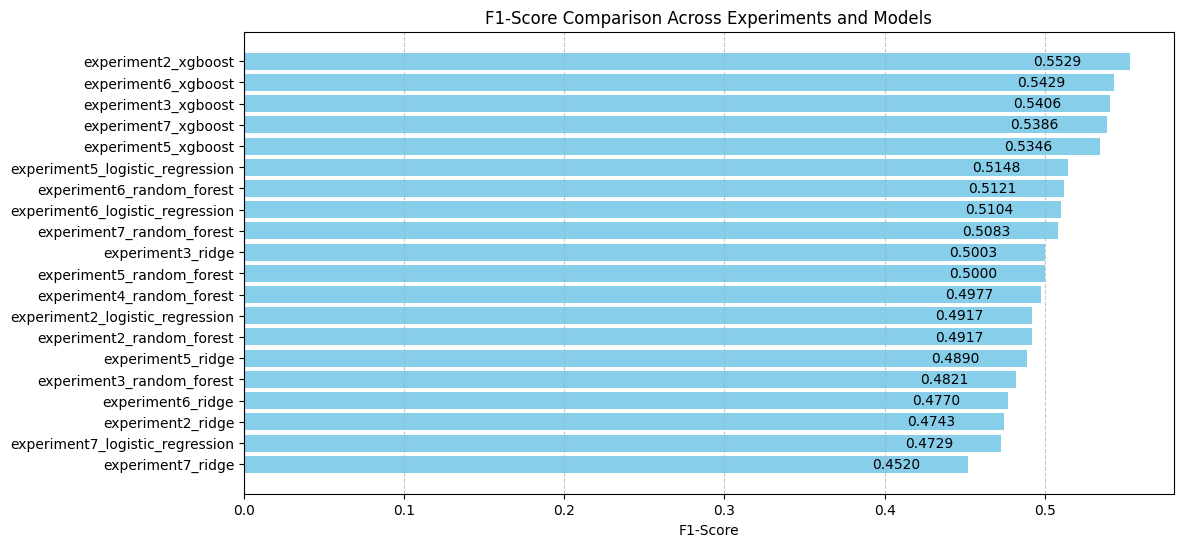

In [ ]:
f1_score_mapping = {
    "experiment2_logistic_regression" : 0.4917,
    "experiment2_ridge" : 0.4743,
    "experiment2_random_forest" : 0.4917 ,
    "experiment2_xgboost" : 0.5529,
    "experiment3_ridge" : 0.5003,
    "experiment3_random_forest" : 0.4821 ,
    "experiment3_xgboost" : 0.5406,
    "experiment4_random_forest" : 0.49771,
    "experiment5_logistic_regression" : 0.51475,
    "experiment5_ridge" : 0.48904,
    "experiment5_random_forest" : 0.5000 ,
    "experiment5_xgboost" : 0.5346,
    "experiment6_logistic_regression" : 0.51040,
    "experiment6_ridge" : 0.4770,
    "experiment6_random_forest" : 0.51212 ,
    "experiment6_xgboost" : 0.54292,
    "experiment7_logistic_regression" : 0.4729,
    "experiment7_ridge" : 0.45203,
    "experiment7_random_forest" : 0.5083 ,
    "experiment7_xgboost" : 0.53861

}
f1_scores_df = pd.DataFrame(f1_score_mapping.items(), columns=['Experiment', 'F1-Score'])
f1_scores_df = f1_scores_df.sort_values(by='F1-Score', ascending=False)

plt.figure(figsize=(12, 6))
bars = plt.barh(f1_scores_df['Experiment'], f1_scores_df['F1-Score'], color='skyblue')
plt.grid(axis='x', linestyle='--', alpha=0.7)
for bar in bars:
    plt.text(bar.get_width() - 0.03, bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.4f}', va='center', ha='right', color='black')
plt.xlabel('F1-Score')
plt.title('F1-Score Comparison Across Experiments and Models')
plt.gca().invert_yaxis()
plt.show()